In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from pandas import DataFrame
from pandas import concat
from scipy.stats import linregress as lr
from scipy.signal import find_peaks as find_peaks
from scipy.fftpack import fft, ifft,rfft
from sklearn.decomposition import PCA

# 0. Preprocessing and Reading Data

In [2]:
patient = 3
cgmSeries = pd.read_csv("DataFolder/CGMDatenumLunchPat" + str(patient) + ".csv")
cgmData = pd.read_csv("DataFolder/CGMSeriesLunchPat" + str(patient) + ".csv")
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)
insulinBasal = pd.read_csv("DataFolder/InsulinBasalLunchPat" + str(patient) + ".csv")
insulinBasal = insulinBasal.fillna(0)
insulinBolus = pd.read_csv("DataFolder/InsulinBolusLunchPat" + str(patient) + ".csv")
insulinBolus = insulinBolus.fillna(0)
insulinTime = pd.read_csv("DataFolder/InsulinDatenumLunchPat" + str(patient) + ".csv")

# Remove Empty Rows
zero_entries = cgmData.isna().any(axis=1)
cgmData = cgmData[zero_entries == False]

cgmSeries = cgmSeries[zero_entries == False]
insulinBasal = insulinBasal[zero_entries == False]
insulinBolus = insulinBolus[zero_entries == False]
insulinTime = insulinTime[zero_entries == False]

In [3]:
reading_no = 1
# Normalize CGMValues
cgmValues_np = cgmData.values
cgmNorm_np = pre.minmax_scale(cgmValues_np, axis=1)

# CGM Timeseries
cgmSeries_np = cgmSeries.values
timeMins = np.nanmin(cgmSeries_np, axis=1)
cgmSeries_np = cgmSeries_np - timeMins[:, None]

# Normalize insulinBasal
insulinBasal_np = insulinBasal.values
insulinBasalNorm_np = pre.minmax_scale(insulinBasal_np, axis=1)

# Normalize insulinBolus
insulinBolus_np = insulinBolus.values
insulinBolusNorm_np = pre.minmax_scale(insulinBolus_np, axis=1)

# Insluin Timeseries
insulinTime_np = insulinTime.values - timeMins[:, None]

# 1.a Anirudh Features

In [4]:
# Slope between max and min
maxs = np.argmax(cgmNorm_np, axis=1)
mins = [np.argmin(cgmNorm_np[i, maxs[i]:])+maxs[i] for i in range(len(maxs))]

slopes = []
time_diffs = []
for i in range(len(maxs)):
    slope = (cgmNorm_np[i][maxs[i]]-cgmNorm_np[i][mins[i]])/(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    time_diffs.append(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    slopes.append(slope)
    
slopes = np.nan_to_num(slopes)
time_diffs = np.nan_to_num(time_diffs)

/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [5]:
# Regression Error
reg_window_size = 4
reg_errors = []
peak_values = []
peak_heights = []
peak_time_diffs = []
peak_times = []
for j in range(len(cgmNorm_np)):
    errors = np.array([])
    for i in range(len(cgmNorm_np[j])-reg_window_size):
        times = cgmSeries_np[j][i:i+reg_window_size-1]
        if np.isnan(times).any():
            errors = np.append(errors, -1)
            continue
        coeffs = np.polyfit(times, cgmNorm_np[j][i:i+reg_window_size-1], 1)
        poly = np.poly1d(coeffs)
        error = poly(cgmSeries_np[j][i+reg_window_size])-cgmNorm_np[j][i+reg_window_size];
        errors = np.append(errors, error)
    peaks, height_dict = find_peaks(errors, height = 0)
    heights = height_dict['peak_heights']
    sorted_args = heights.argsort()
    peaks = peaks[sorted_args]
    peaks = peaks[-2:]
    heights = heights[sorted_args]
    heights = heights[-2:]
    values = cgmNorm_np[j][peaks+reg_window_size-1]
    times = cgmSeries_np[j][peaks+reg_window_size]
    times2 = cgmSeries_np[j][peaks+reg_window_size-1]
    reg_errors.append(errors)
    while(len(values) < 2):
        values = np.append(values, 0)
        heights = np.append(heights, 0)
        times = np.append(times, 0)
        times2 = np.append(times2, 0)
    peak_values.append(values)
    peak_heights.append(heights)
    peak_time_diffs.append(times)
    peak_times.append(times2)
reg_errors = np.array(reg_errors)

13.088926072896164
0.07640046207234263


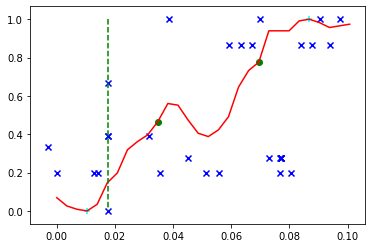

[0.77586207 0.46551724]
[0.20689655 0.26163791]
[0.06945602 0.03472222]


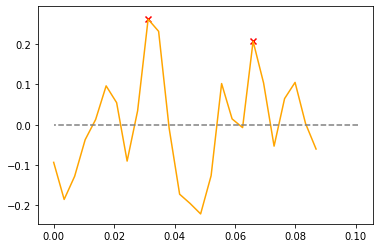

28.800000268220902
0.03472222189884633


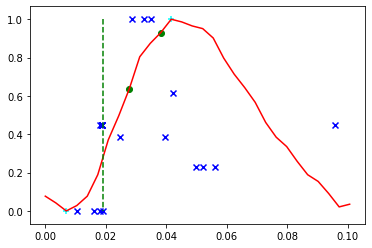

[0.93006993 0.63636364]
[0.16200467 0.18414921]
[0.03819444 0.02777778]


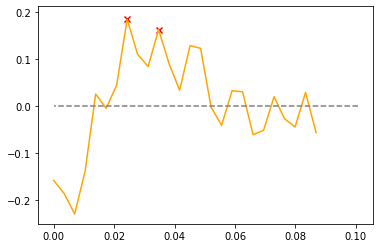

26.181818465556
0.0381944440305233


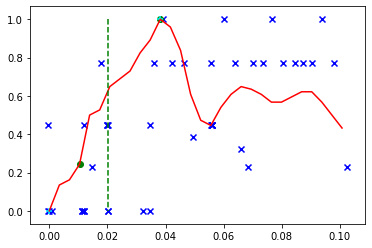

[0.24324324 1.        ]
[0.1734234  0.43520771]
[0.01041667 0.03819444]


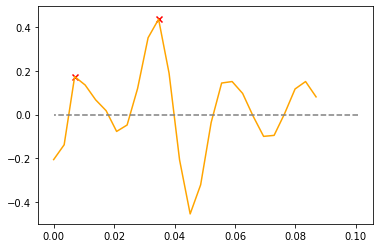

0.0
0.0


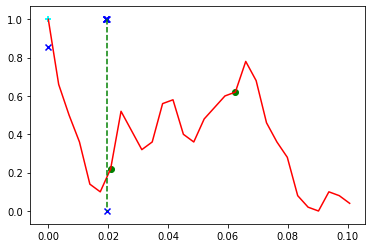

[0.62 0.22]
[0.51999995 0.62000003]
[0.0625     0.02083333]


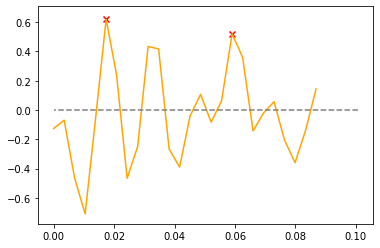

12.00000006146729
0.08333333290647715


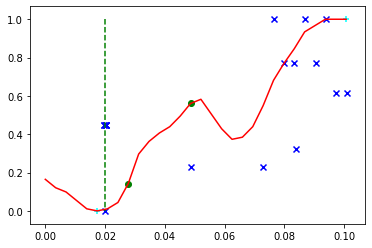

[0.14285714 0.56043956]
[0.14652013 0.24175824]
[0.02777778 0.04861111]


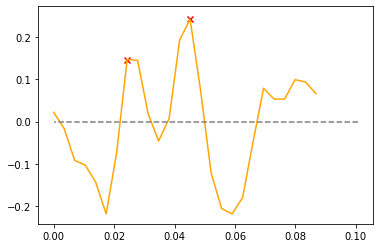

19.200000071525572
0.0520833331393078


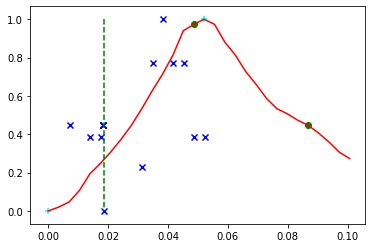

[0.44666667 0.97333333]
[0.03444443 0.19111113]
[0.0868287  0.04861111]


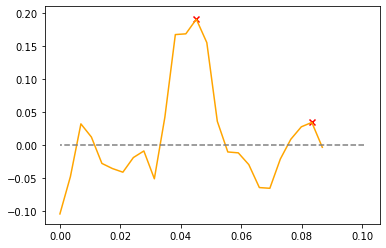

15.997037601697516
0.06251157401129603


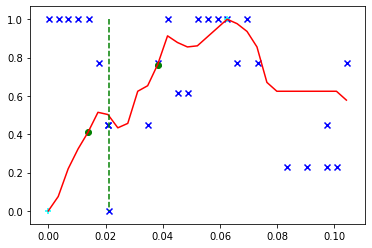

[0.41040462 0.76300578]
[0.28131022 0.31599229]
[0.01388889 0.03820602]


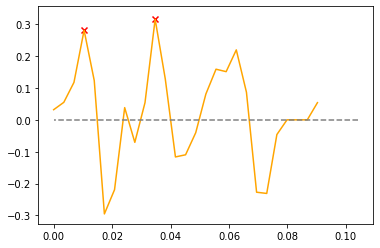

19.191470318016993
0.052106481860391796


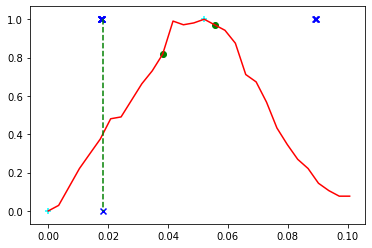

[0.97115385 0.81730769]
[0.18910253 0.26442308]
[0.0555787  0.03821759]


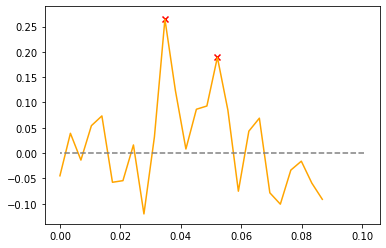

26.18181854535726
0.03819444391410798


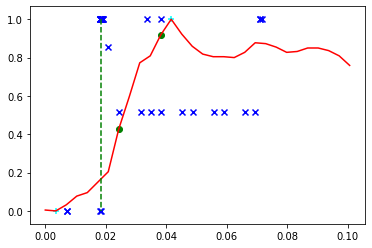

[0.42727273 0.91818182]
[0.20075759 0.32954544]
[0.02430555 0.03819444]


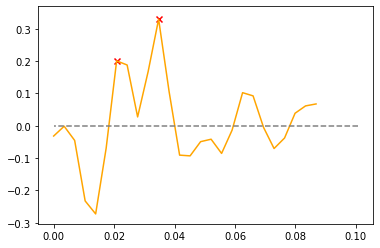

22.153846103058765
0.045138888992369175


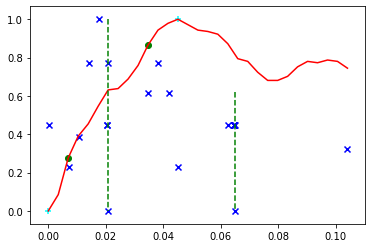

[0.86524823 0.27659574]
[0.13002365 0.14420805]
[0.03472222 0.00694444]


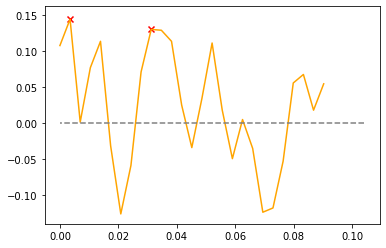

35.38983261787298
0.0138888880610466


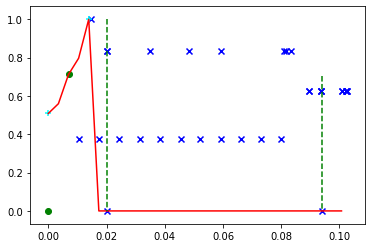

[0.71186441 0.        ]
[1.2344632 0.       ]
[0.00694444 0.        ]


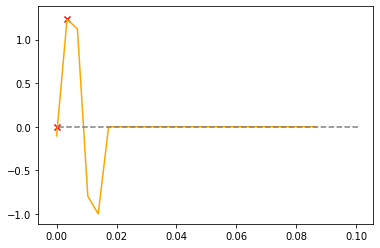

23.999999821186066
0.041666666977107525


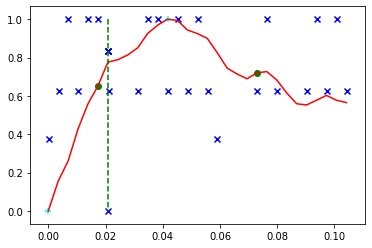

[0.72049689 0.65217391]
[0.1528163  0.17805384]
[0.07291667 0.01736111]


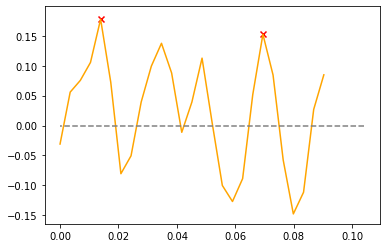

10.665349963936439
0.09376157401129603


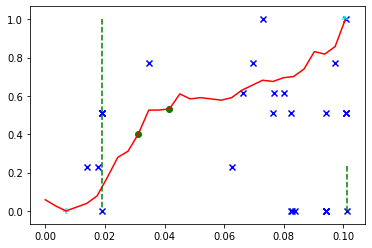

[0.53246753 0.4025974 ]
[0.09842003 0.20670996]
[0.04166667 0.03125   ]


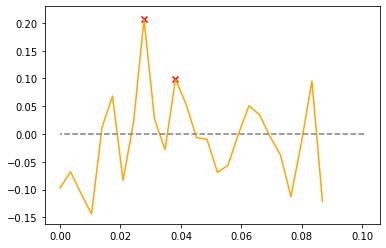

9.59893342901915
0.10417824098840356


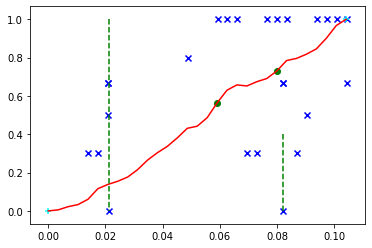

[0.72928177 0.56353591]
[0.05893187 0.12707182]
[0.07987269 0.05903935]


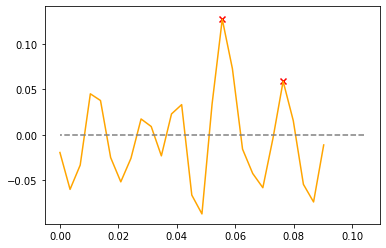

16.941176411189836
0.05902777798473835


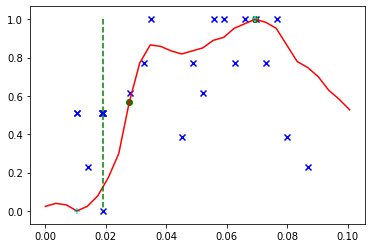

[1.         0.56692913]
[0.13517061 0.40288714]
[0.06944445 0.02777778]


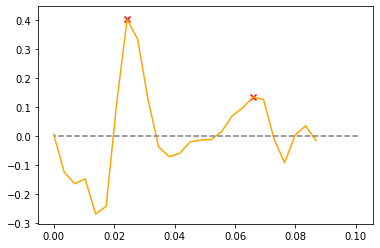

22.153846160194572
0.04513888887595385


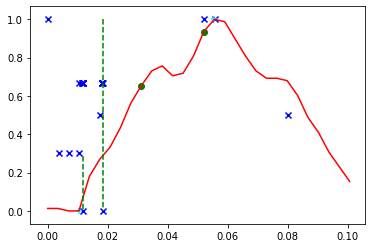

[0.65384615 0.93589744]
[0.2051282  0.30769232]
[0.03125    0.05208333]


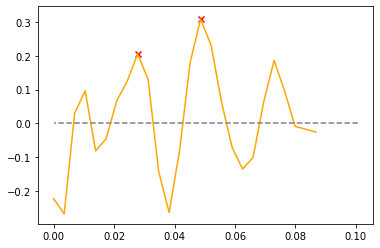

0.0
0.0


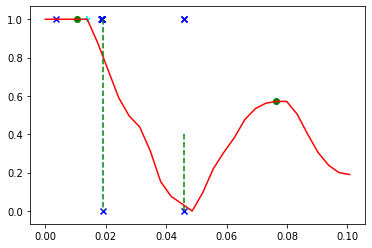

[0.57142857 1.        ]
[0.18730156 0.26984131]
[0.07641204 0.01041667]


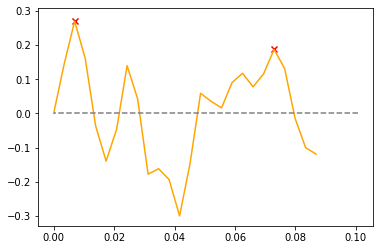

9.59999997138977
0.10416666697710752


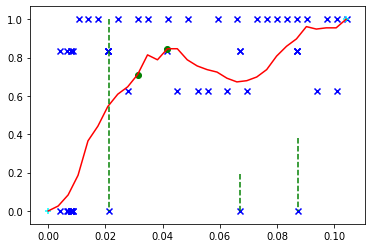

[0.71153846 0.84615385]
[0.1207265  0.14316238]
[0.03125    0.04166667]


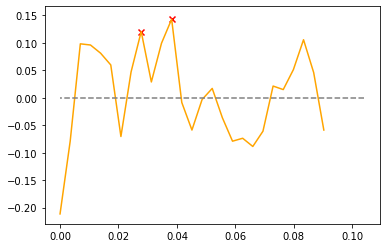

14.519667404983046
0.06597222306299955


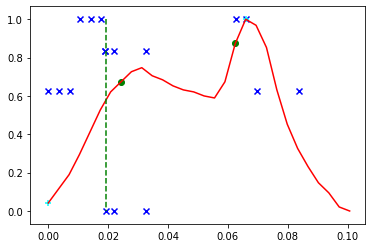

[0.67368421 0.87368421]
[0.13684211 0.48771932]
[0.02430556 0.0625    ]


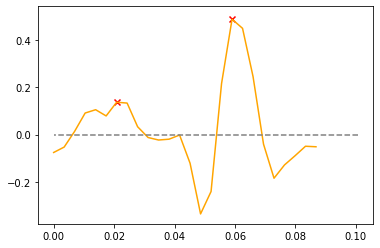

29.462771144436722
0.03126157505903393


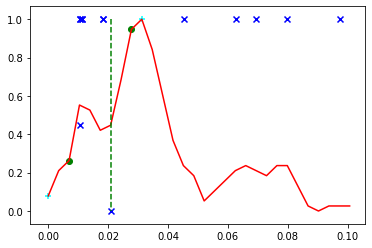

[0.26315789 0.94736842]
[0.48684209 0.72368427]
[0.00695602 0.02778935]


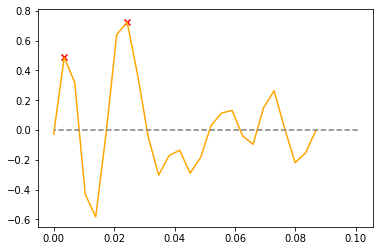

10.666666666666666
0.09375


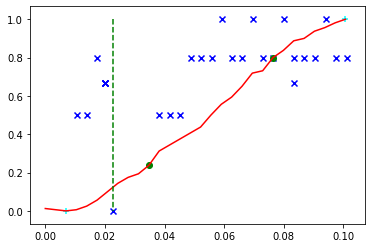

[0.8    0.2375]
[0.05000001 0.05624999]
[0.07638889 0.03472222]


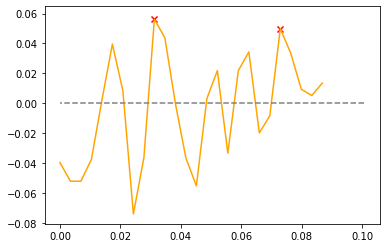

0.0
0.0


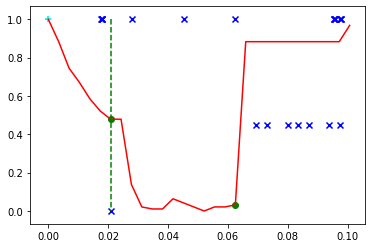

[0.4787234  0.03191489]
[0.37765965 0.86170213]
[0.02083333 0.0625    ]


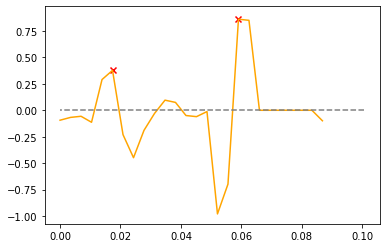

12.000000044703484
0.08333333302289248


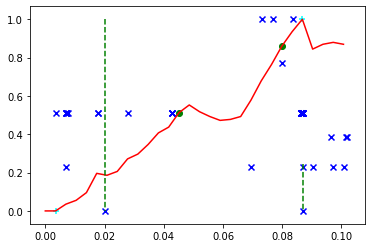

[0.51256281 0.85929648]
[0.17420436 0.29815745]
[0.04513889 0.07986111]


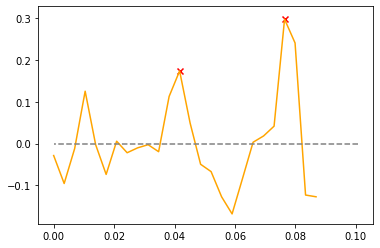

22.148167002452453
0.04515046323649585


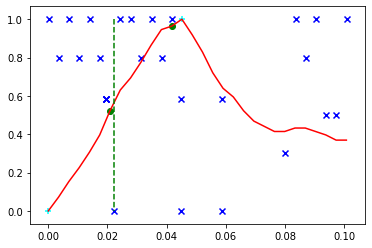

[0.52252252 0.96396396]
[0.08708711 0.22672671]
[0.02084491 0.04167824]


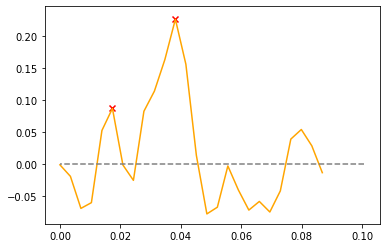

20.571428615219737
0.048611111007630825


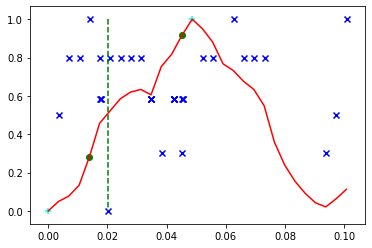

[0.28169014 0.91549296]
[0.1971831  0.30633803]
[0.01388889 0.04513889]


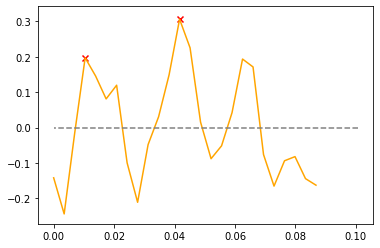

20.561637461614403
0.04863425891380757


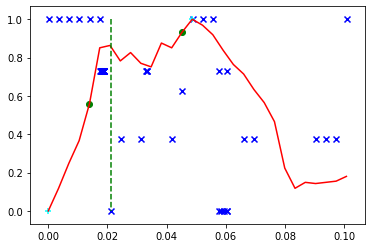

[0.93167702 0.55900621]
[0.23291924 0.56855071]
[0.04516204 0.01391204]


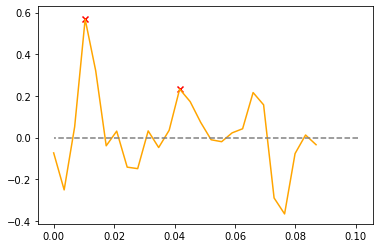

12.521739128406647
0.07986111112404615


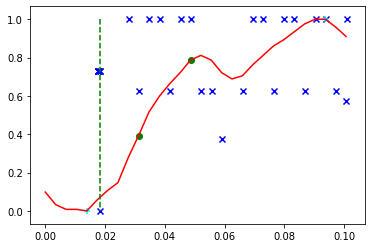

[0.39344262 0.78688525]
[0.09289616 0.18715847]
[0.03125    0.04861111]


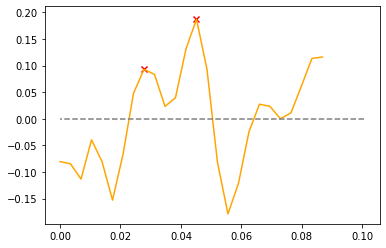

13.714285634001907
0.07291666709352285


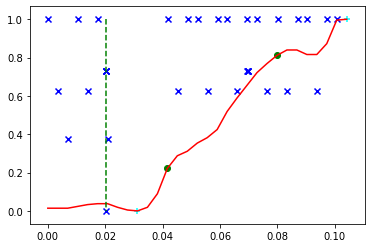

[0.81132075 0.22169811]
[0.09827044 0.12893083]
[0.07986111 0.04166667]


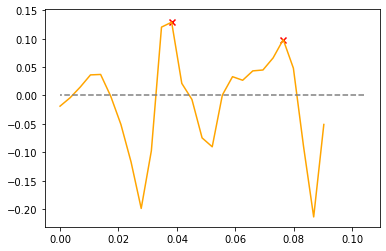

20.032257915264175
0.02777777798473835


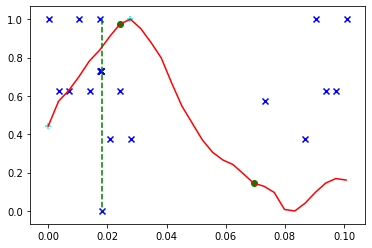

[0.14516129 0.97580645]
[0.06586023 0.21370969]
[0.06945602 0.02430556]


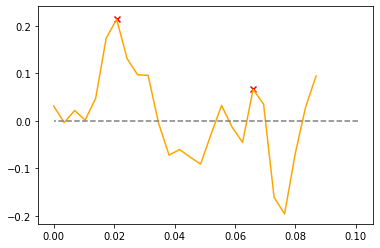

15.999999999999998
0.0625


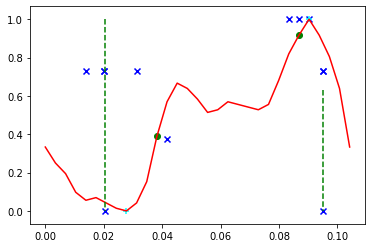

[0.38888889 0.91666667]
[0.36805555 0.37962966]
[0.03819444 0.08680556]


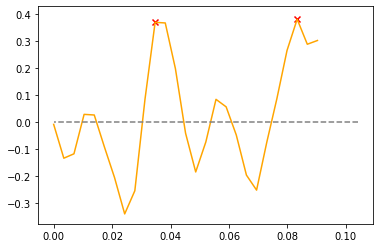

0.0
0.0


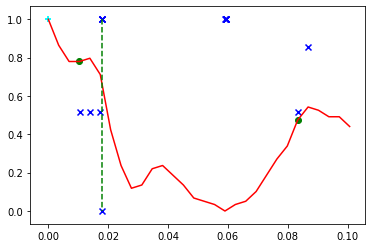

[0.47457627 0.77966102]
[0.25706214 0.42372888]
[0.08333333 0.01041667]


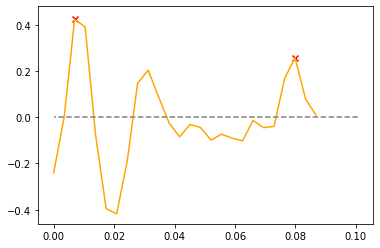

10.66666666666667
0.09375


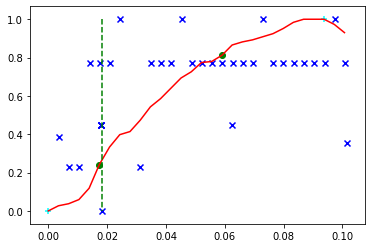

[0.81182796 0.24193548]
[0.06003585 0.14247311]
[0.05902778 0.01736111]


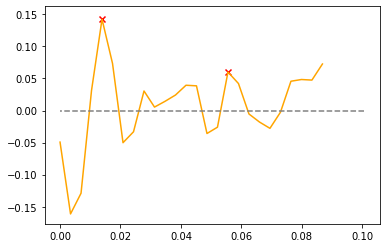

8.752941331355014
0.04166666592936963


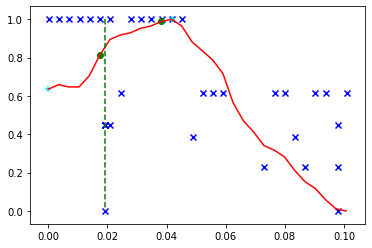

[0.81176471 0.98823529]
[0.15490196 0.1607843 ]
[0.01736111 0.03819444]


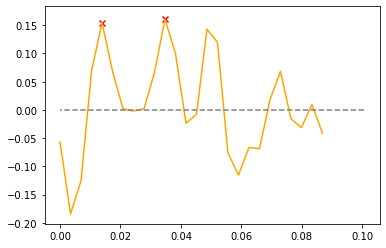

32.0
0.03125


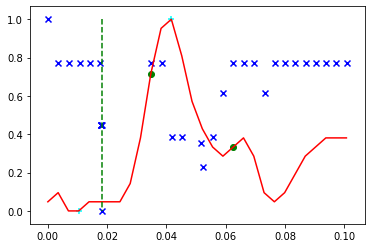

[0.33333333 0.71428571]
[0.39682544 0.7537273 ]
[0.06253472 0.03472222]


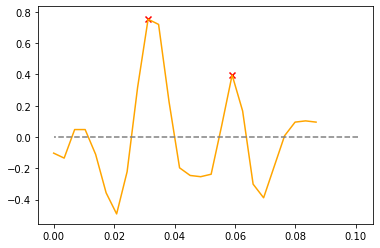

12.521739000634119
0.0798611119389534


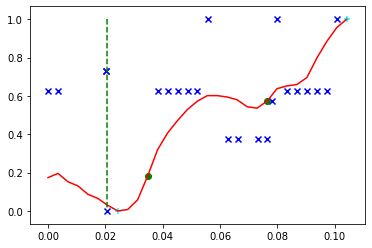

[0.57246377 0.18115942]
[0.08091788 0.11231886]
[0.07638889 0.03472222]


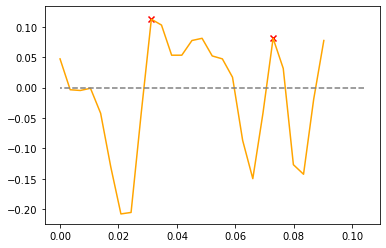

28.80000036478043
0.017361110891215503


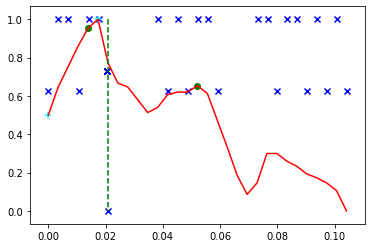

[0.65333333 0.95333333]
[0.27333328 0.45333338]
[0.05208333 0.01388889]


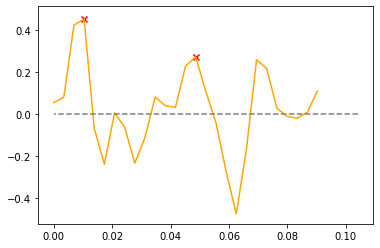

In [6]:
# Visualize
for i in range(0, len(cgmSeries_np)):
    print(slopes[i])
    print(time_diffs[i])
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    plt.scatter(peak_times[i], peak_values[i], marker='o', c='green')
    plt.scatter(cgmSeries_np[i][maxs[i]], cgmNorm_np[i][maxs[i]], marker='+', c='cyan')
    plt.scatter(cgmSeries_np[i][mins[i]], cgmNorm_np[i][mins[i]], marker='+', c='cyan')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()
    print(peak_values[i])
    print(peak_heights[i])
    print(peak_times[i])
    plt.figure()
    plt.plot(cgmSeries_np[i][reg_window_size:], reg_errors[i], c='orange')
    plt.plot(cgmSeries_np[i], np.zeros(len(cgmSeries_np[i])), c='gray', linestyle='dashed')
    plt.scatter(peak_time_diffs[i], peak_heights[i], c='red', marker='x')
    plt.show()    

# 1.b Vedant Features

In [7]:
# Windowed features
window_mins = []
window_maxs = []
window_means = []
window_vars = []
for i in range(0, len(cgmSeries_np)):
    window_input = DataFrame(cgmNorm_np[i][::-1])
    width=5
    shifted=window_input.shift(width - 1)
    window=shifted.rolling(window=width)
    dataframe=concat([window.var(), window.min(),  window.mean(), window.max() ], axis=1)
    dataframe.columns = ['var', 'min', 'mean', 'max']
    window_features = dataframe.nlargest(2,'var')
    window_values = window_features.values
    window_mins.append([window_values[0][1], window_values[1][1]])
    window_maxs.append([window_values[0][3], window_values[1][3]])
    window_vars.append([window_values[0][0], window_values[1][0]])
    window_means.append([window_values[0][2], window_values[1][2]])

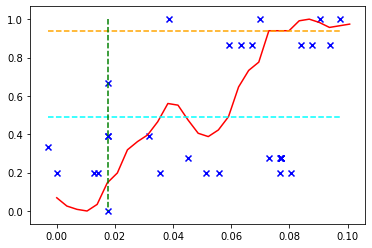

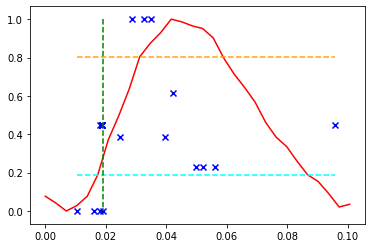

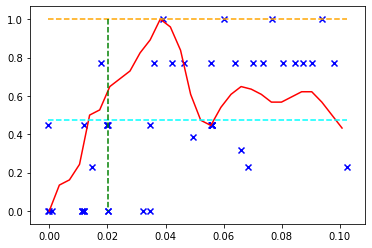

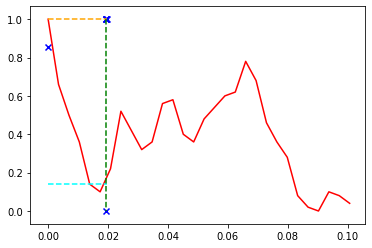

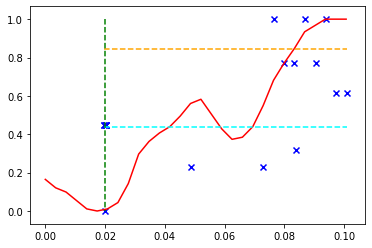

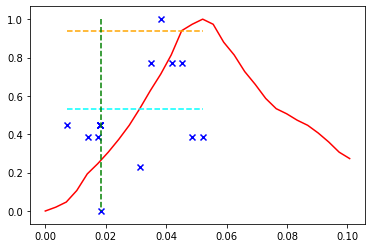

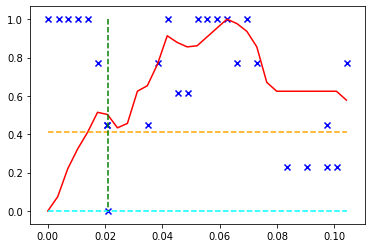

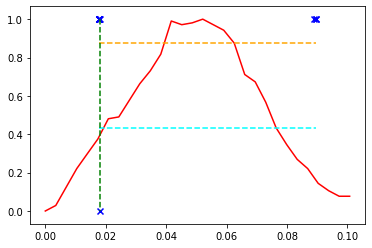

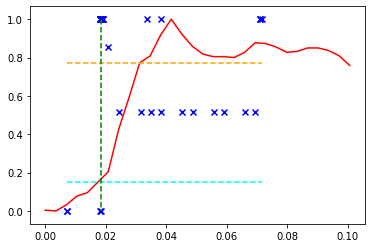

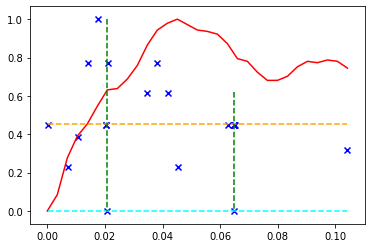

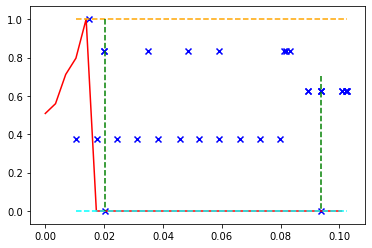

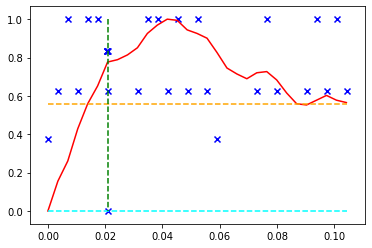

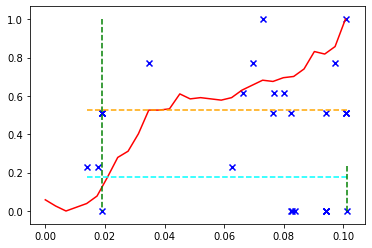

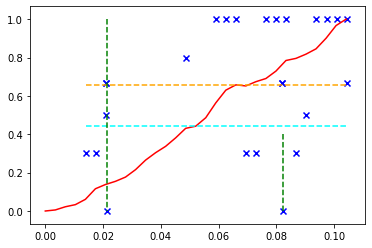

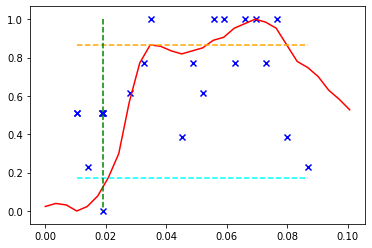

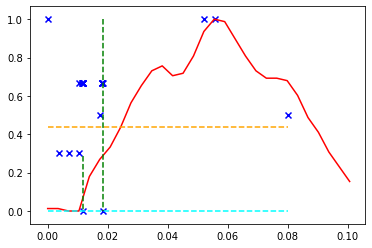

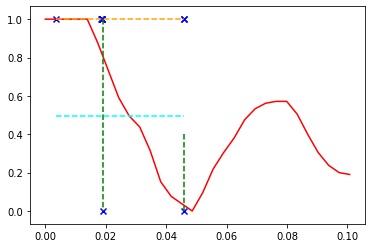

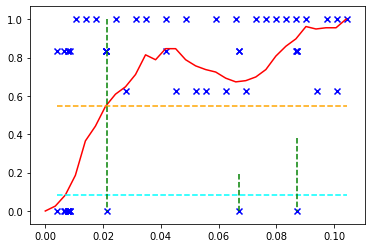

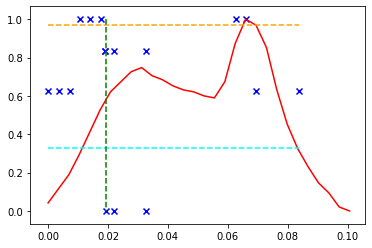

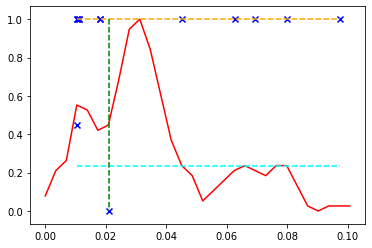

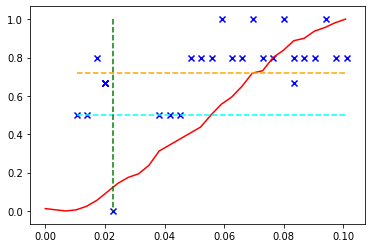

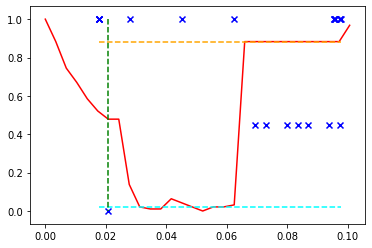

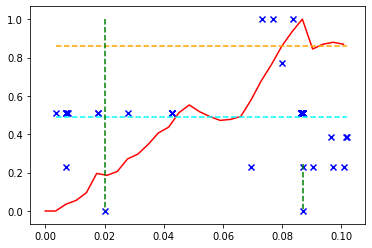

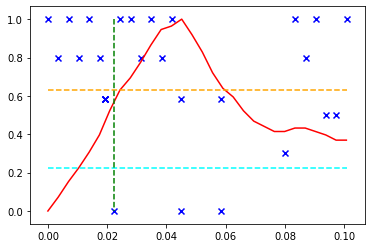

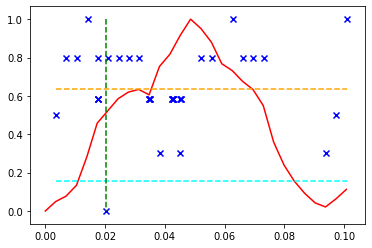

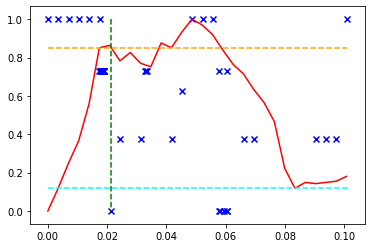

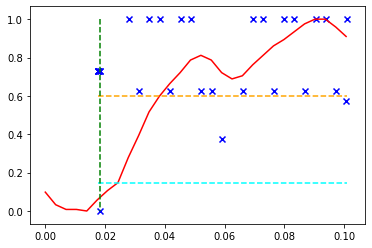

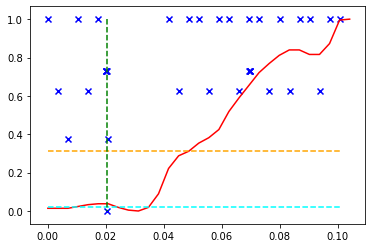

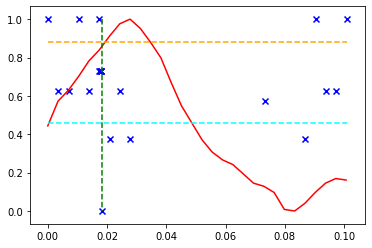

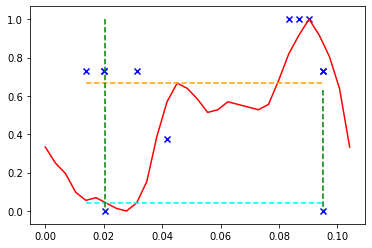

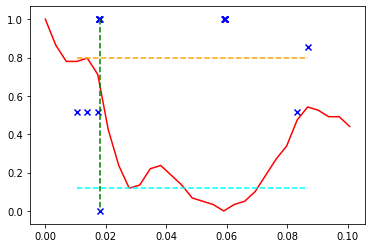

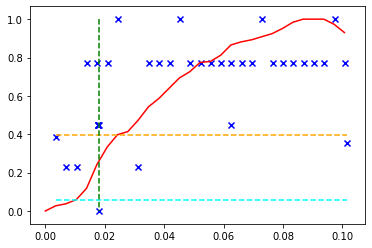

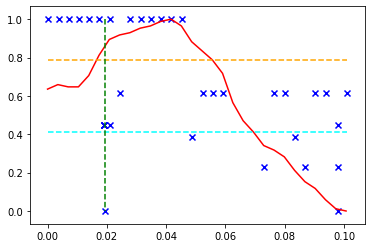

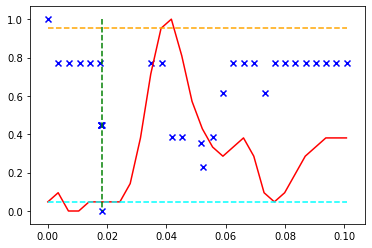

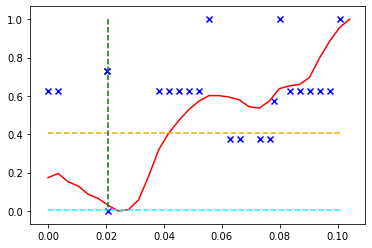

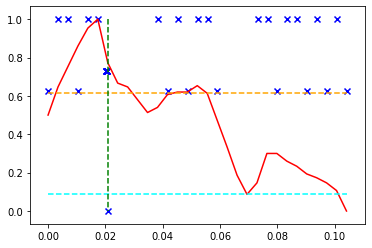

In [8]:
# Visualize
for i in range(0, len(cgmSeries_np)):
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    po1 = np.nanmin(insulinTime_np[i])
    po2 = np.nanmax(insulinTime_np[i])
    plt.plot([po1, po2], [window_mins[i][0], window_mins[i][0]], c='cyan', linestyle='dashed')
    plt.plot([po1, po2], [window_maxs[i][0], window_maxs[i][0]], c='orange', linestyle='dashed')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()

# 1.c Omkar Features

In [9]:
# series = cgmNorm_np
# datenum = cgmSeries_np
# InsulinBolus = insulinBolusNorm_np
# InsulinTimestamp = insulinTime_np

In [10]:
maximum=[]
for i in range(insulinBolusNorm_np[:,0].size):
    maximum.append(np.nanargmax(insulinBolusNorm_np[i]))
# print(maximum)

In [11]:
def slope(time,values):
    slope = []
    for i in range(len(values)-1):
        slope.append((values[i+1]-values[i])/(time[i+1]-time[i])) 
    slope.append(np.nan)
    slope = np.asarray(slope)
    
    return slope

0.5926724137931034


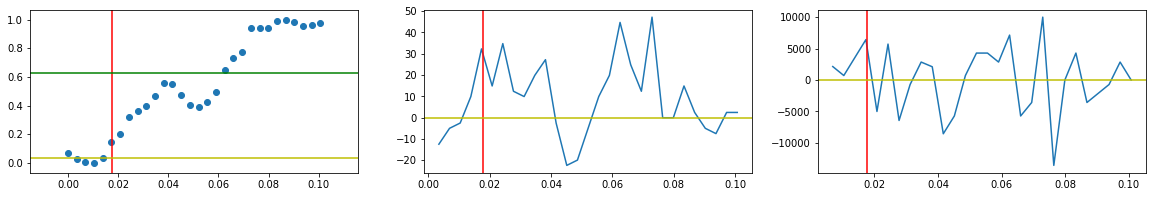

0.4907024793388429


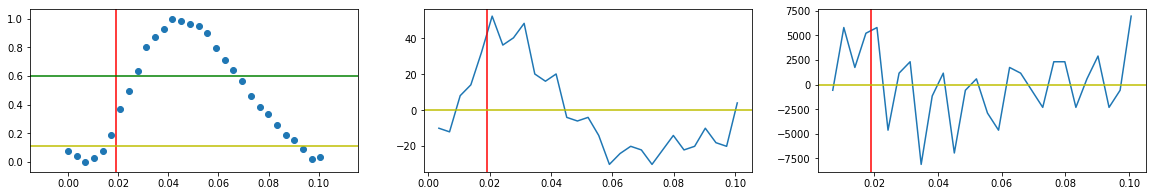

0.18768768768768762


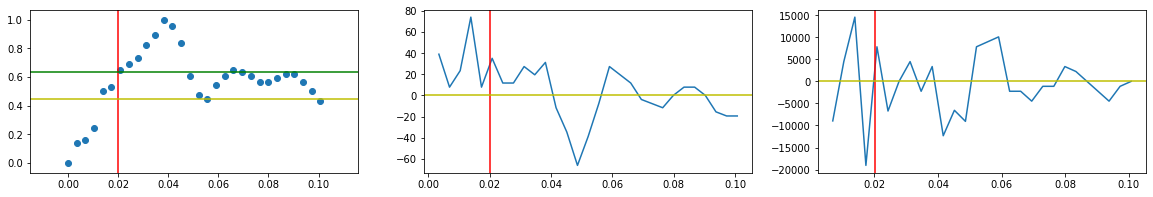

-0.5192592592592593


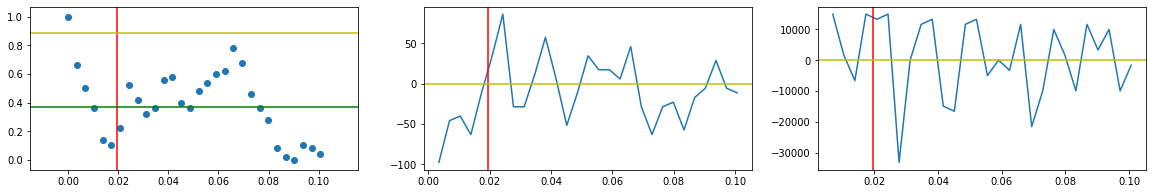

0.2720727548313755


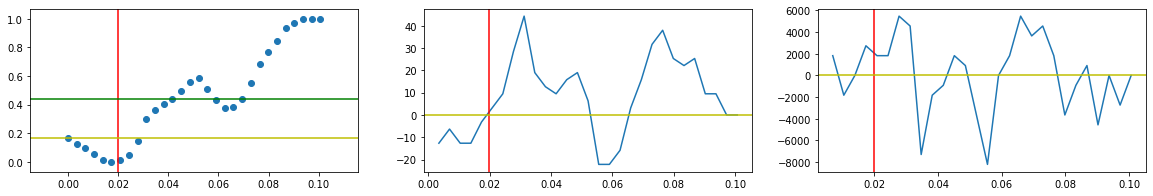

0.5491666666666667


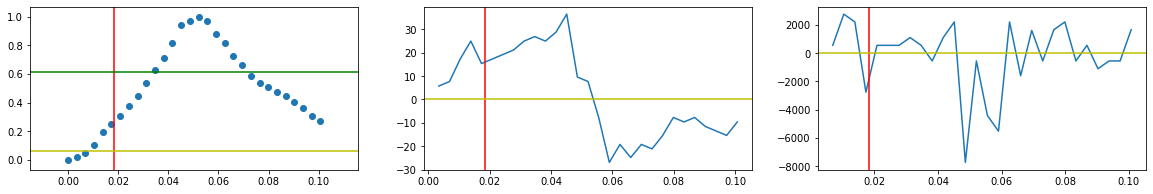

0.4515851075288118


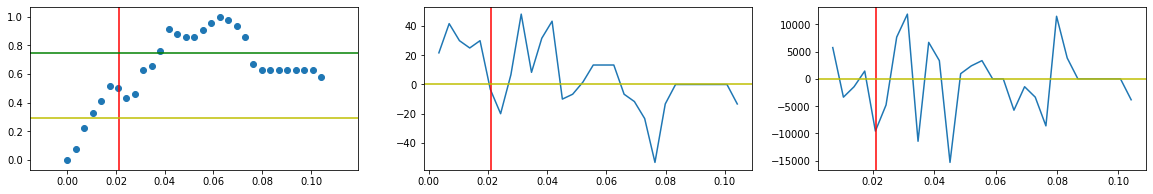

0.48838141025641024


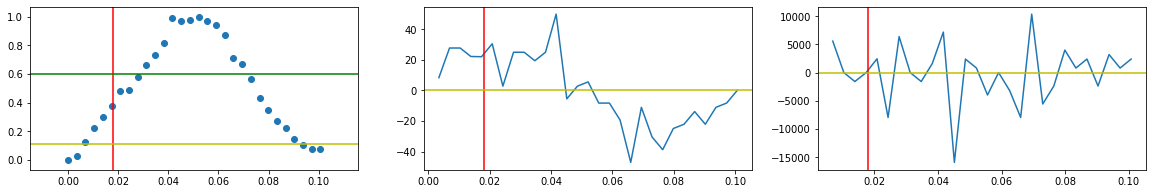

0.7457128099173553


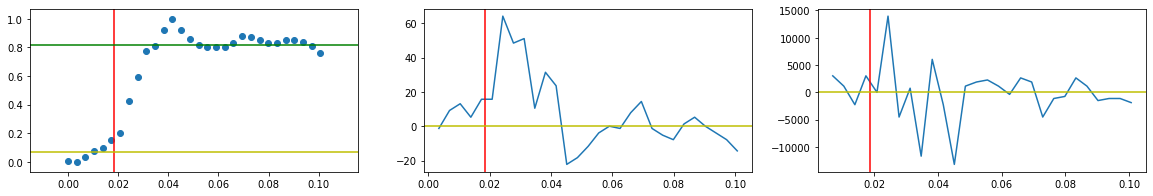

0.5156619385342789


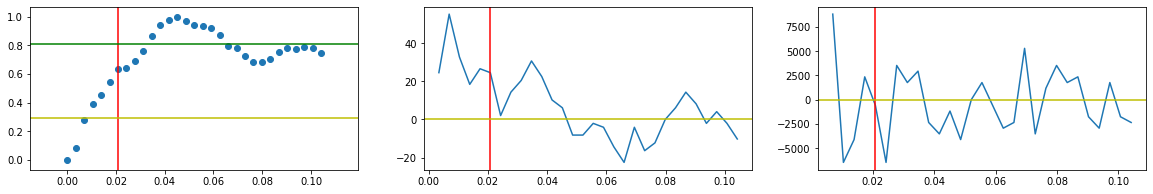

-0.5029335071707952


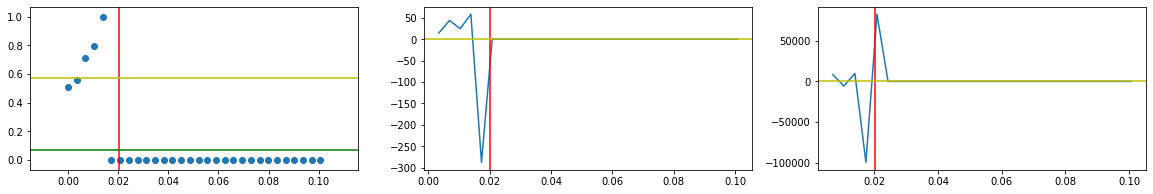

0.2738834664300503


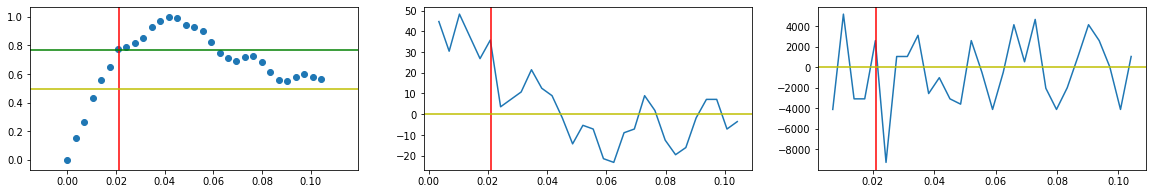

0.5153246753246753


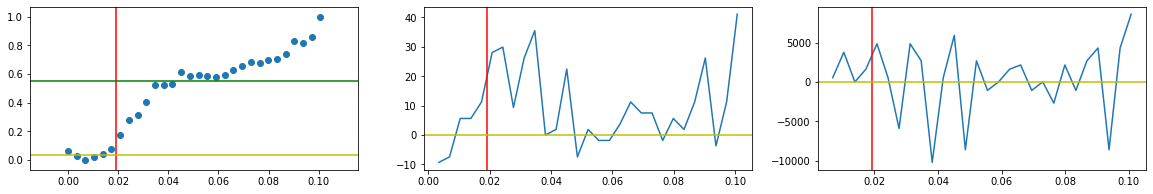

0.49309392265193364


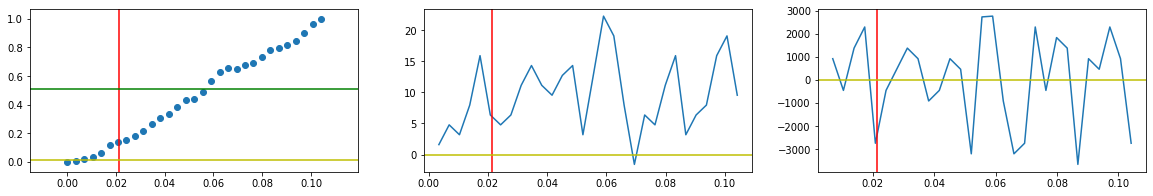

0.7230971128608924


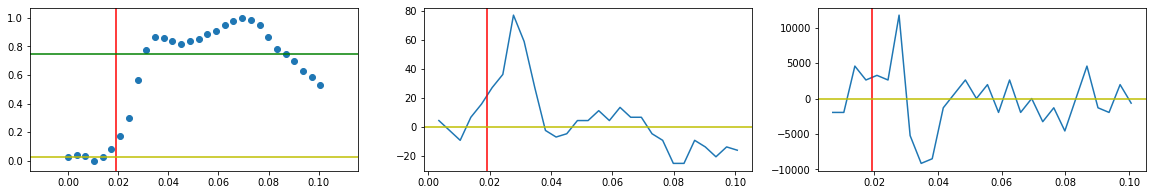

0.23651235642185875


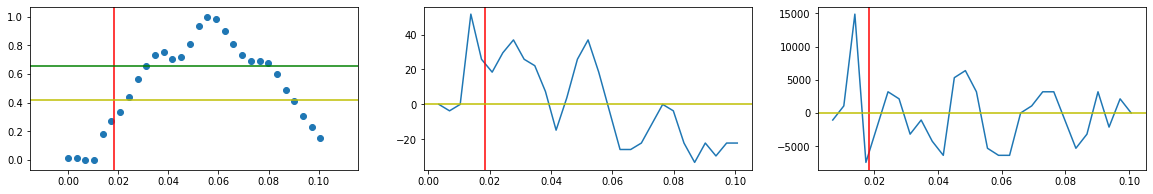

-0.5969523809523811


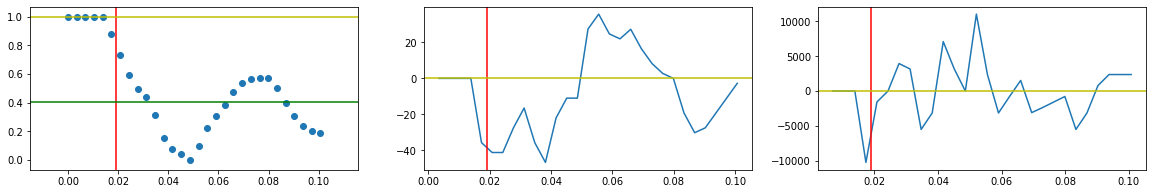

0.2858974358974359


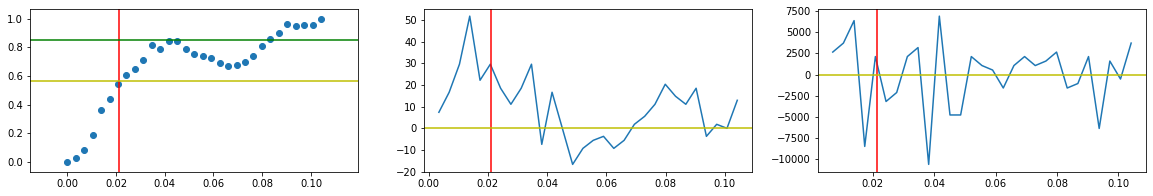

0.35652173913043483


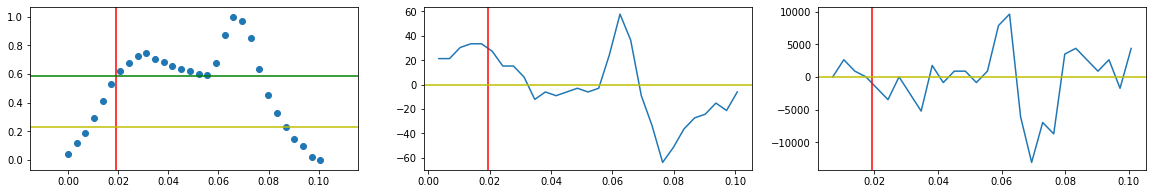

0.030701754385964952


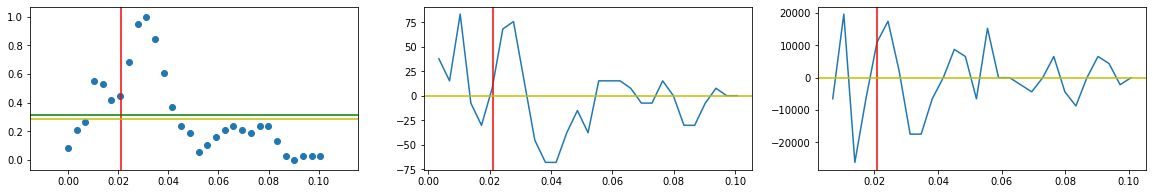

0.52421875


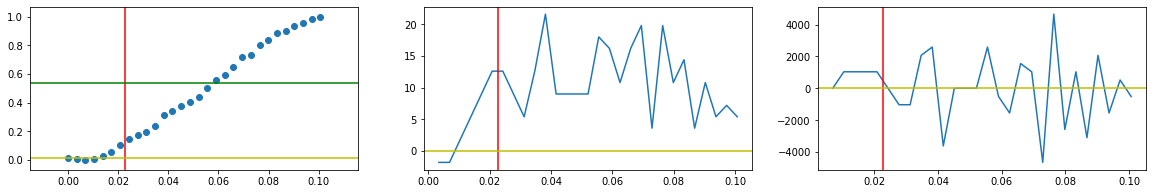

-0.4909377462568952


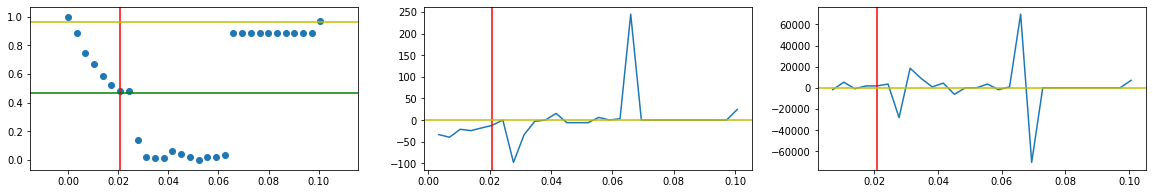

0.5149040657834629


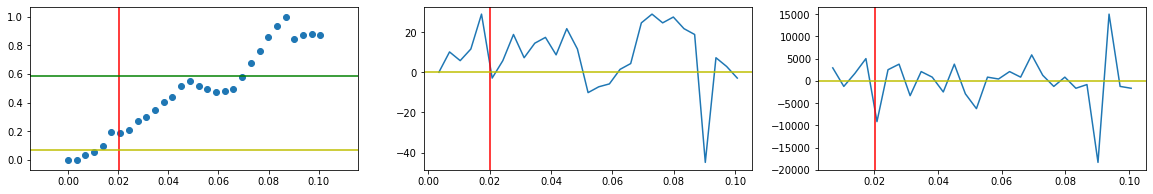

0.3748033748033747


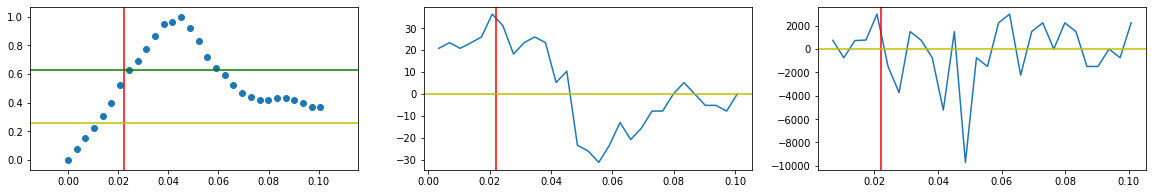

0.40552007698364095


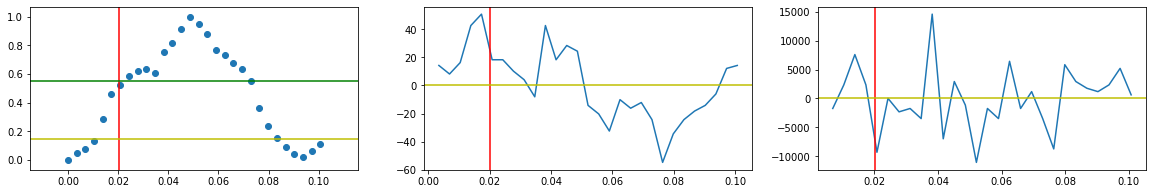

-0.33260869565217394


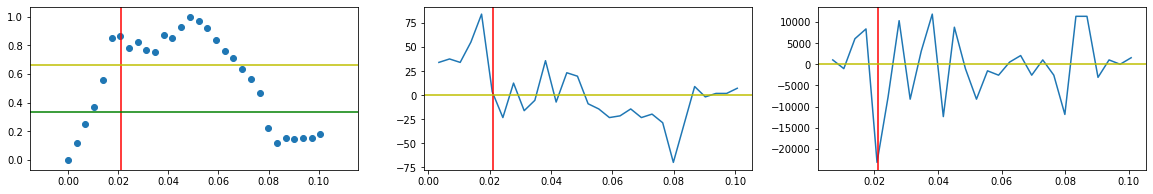

0.598032786885246


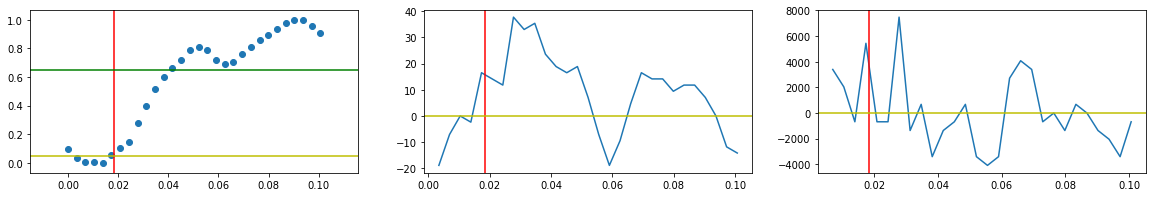

0.5177448337825695


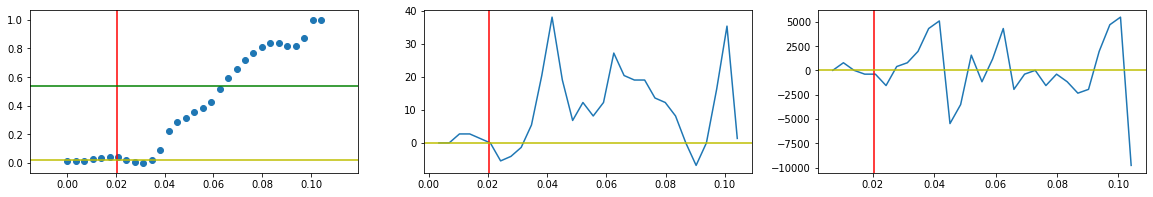

-0.40403225806451604


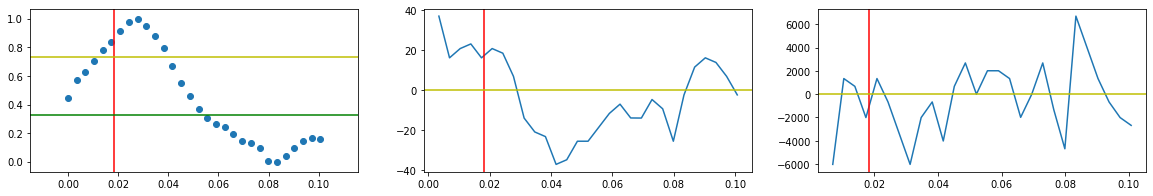

0.17559523809523808


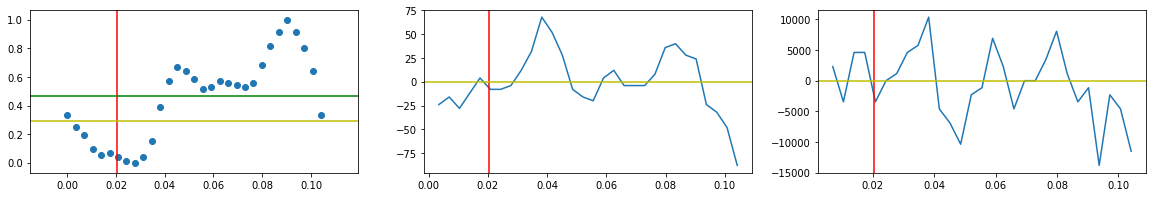

-0.6172316384180789


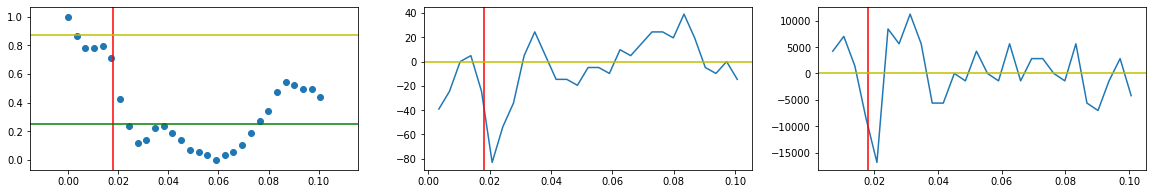

0.6805962854349952


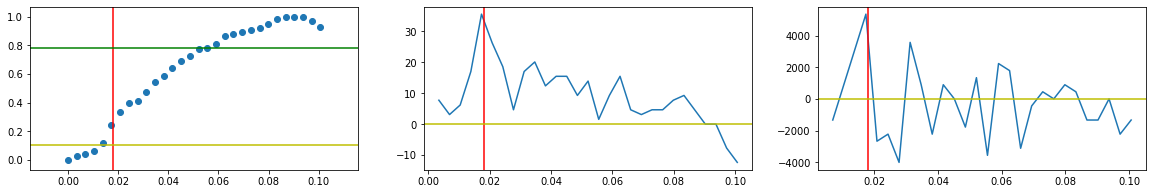

-0.15835667600373493


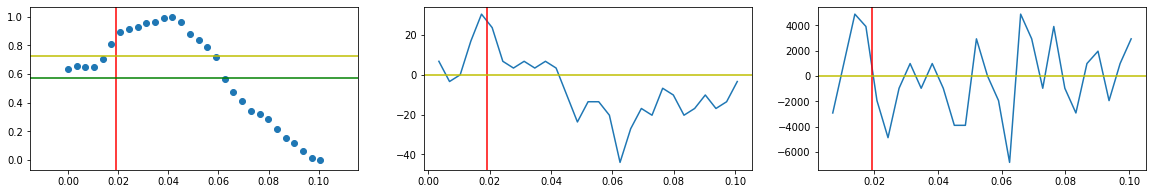

0.3590325018896443


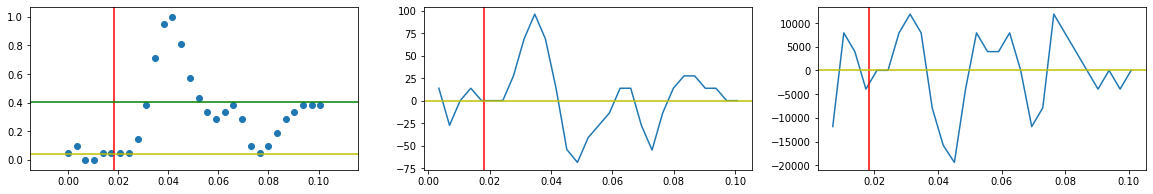

0.2767042404723565


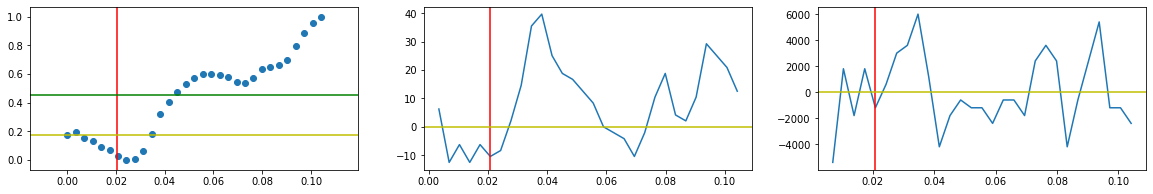

-0.36648148148148146


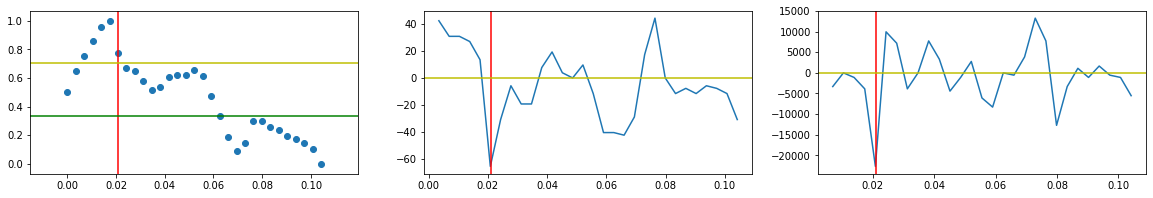

[0.5926724137931034, 0.4907024793388429, 0.18768768768768762, -0.5192592592592593, 0.2720727548313755, 0.5491666666666667, 0.4515851075288118, 0.48838141025641024, 0.7457128099173553, 0.5156619385342789, -0.5029335071707952, 0.2738834664300503, 0.5153246753246753, 0.49309392265193364, 0.7230971128608924, 0.23651235642185875, -0.5969523809523811, 0.2858974358974359, 0.35652173913043483, 0.030701754385964952, 0.52421875, -0.4909377462568952, 0.5149040657834629, 0.3748033748033747, 0.40552007698364095, -0.33260869565217394, 0.598032786885246, 0.5177448337825695, -0.40403225806451604, 0.17559523809523808, -0.6172316384180789, 0.6805962854349952, -0.15835667600373493, 0.3590325018896443, 0.2767042404723565, -0.36648148148148146]


In [12]:
mean_before = []
mean_after = []
mean_dif = []
for i in range(0,len(cgmNorm_np)):
    fig = plt.figure(figsize=(20,3))
    
    sl = slope(cgmSeries_np[i],cgmNorm_np[i])
    
    
    sl_1 = slope(cgmSeries_np[i],sl)
    sl_2 = slope(cgmSeries_np[i],sl_1)
    sl_3 = slope(cgmSeries_np[i],sl_2)
#     cut = insulinTime_np[i,maximum[i]]
#     print(maximum[i])
#     print(cut)
#     cut1 = np.where(insulinTime_np[i]==cut)
#     print(int(cut1[0]))
#     print(cut1)
    mean1 = np.nanmean(cgmNorm_np[i][-1:-maximum[i]:-1])
    mean2 = np.nanmean(cgmNorm_np[i][-maximum[i]:0:-1])
    
    mean_before.append(mean1)
    mean_after.append(mean2)
    
    print(mean2-mean1)
    
    plt.subplot(1,3,1)
    plt.scatter(cgmSeries_np[i],cgmNorm_np[i])
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = mean1,c='y')
    plt.axhline(y = mean2,c='g')
    
    plt.subplot(1,3,2)
    plt.plot(cgmSeries_np[i],sl)
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = 0,c='y')
    
    plt.subplot(1,3,3)
    plt.plot(cgmSeries_np[i],sl_1)
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = 0,c='y')
    plt.show()

mean_dif = [x - y for x, y in zip(mean_after, mean_before)]
print(mean_dif)

# 1.d Ananth Features

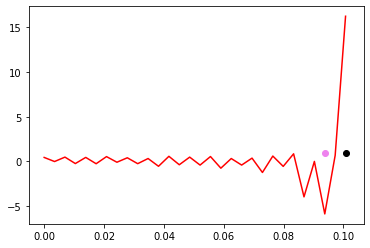

[16.23275862068966, -5.877074392438965, 0.26505483531442803, 10.28379113775924]


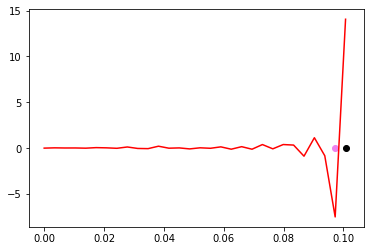

[14.055944055944055, -7.5160381855702, 0.2294012147385561, 8.249634519607687]


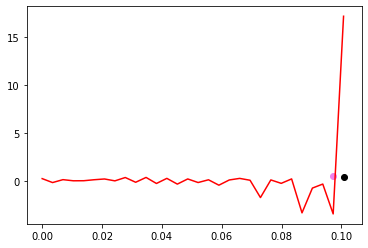

[17.189189189189193, -3.4512267927737463, 0.27349432264737567, 10.358458001029735]


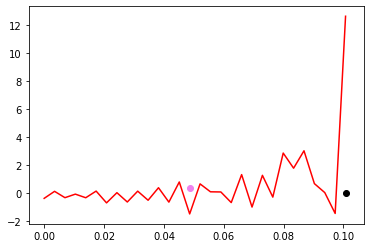

[12.620000000000005, -1.4726485094796553, 0.5836565725069344, 5.874725650530752]


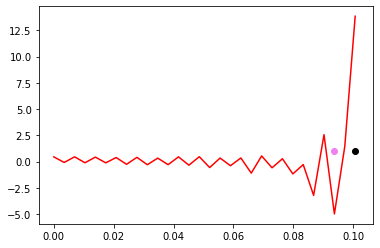

[13.835164835164836, -4.981139065082994, 0.2878948813836156, 7.695201621278084]


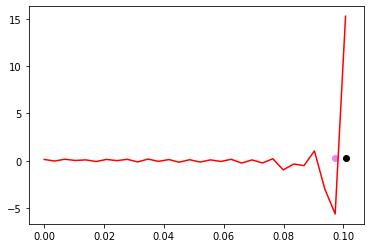

[15.286666666666669, -5.6342455443435755, 0.20037942723745408, 8.900493246430312]


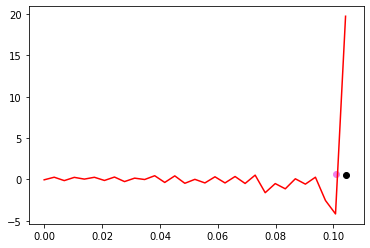

[19.734104046242773, -4.160667933541003, 0.3350718558985441, 13.432658458338363]


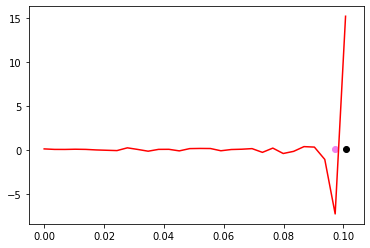

[15.16346153846154, -7.292589382056879, 0.2311110357184811, 9.14391184454229]


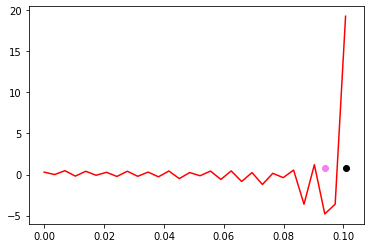

[19.295454545454547, -4.805278600204271, 0.26756502907640334, 13.735187147697346]


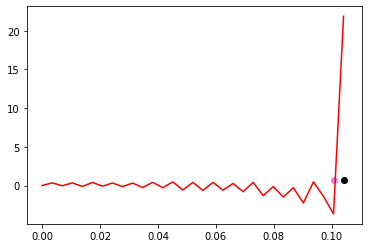

[21.879432624113477, -3.6579025288576306, 0.40850542678736973, 16.179239157151333]


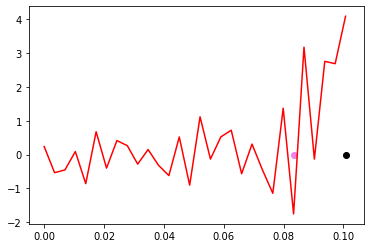

[4.084745762711864, -1.7532647872546008, 0.3278550083574959, 1.6472626943511666]


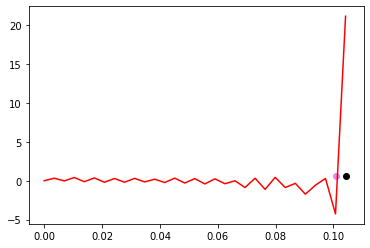

[21.099378881987576, -4.264026656597858, 0.4176654524542306, 15.031034749119113]


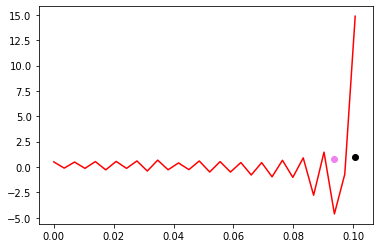

[14.857142857142861, -4.623144540676215, 0.3290812937199193, 8.288719359652777]


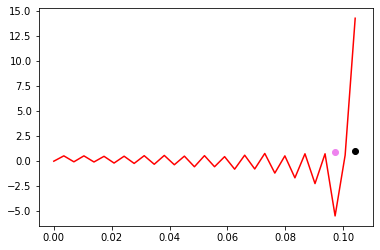

[14.276243093922648, -5.494745331968555, 0.2533506254163294, 8.018333884669502]


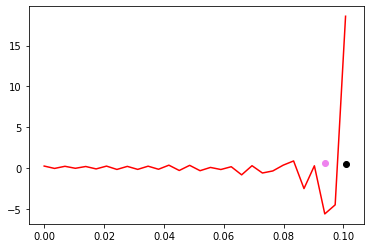

[18.590551181102363, -5.61082667784712, 0.2184860368753896, 13.073096093354966]


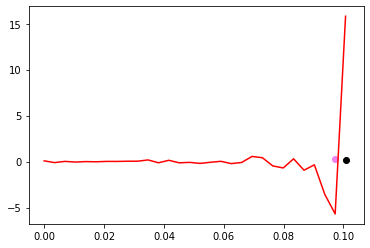

[15.807692307692305, -5.688305984682372, 0.15753545665089577, 9.568589930749313]


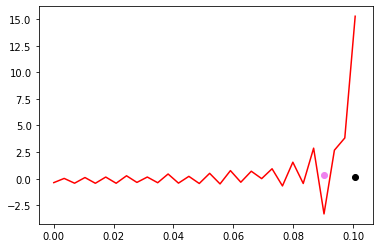

[15.266666666666667, -3.3106528631615815, 0.7092326167329878, 8.574341154465294]


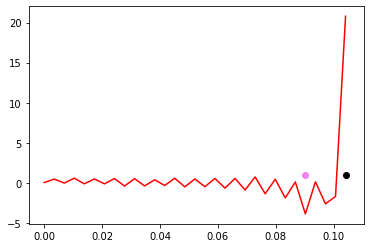

[20.78205128205128, -3.85539230221159, 0.40498754164542744, 14.908643942461909]


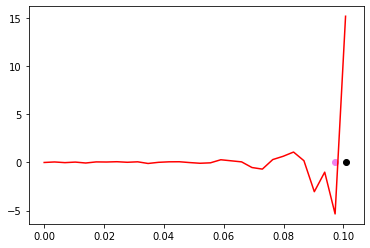

[15.147368421052633, -5.3427427326232255, 0.23373315875169948, 8.681792722572155]


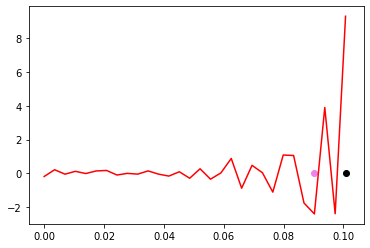

[9.315789473684207, -2.4077150338364017, 0.2613116080770405, 3.8827036440739477]


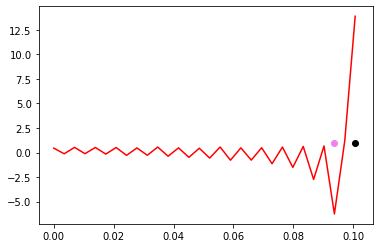

[13.893749999999999, -6.256150478172224, 0.2191070440901263, 8.042140792746215]


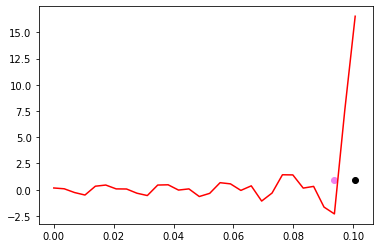

[16.54255319148936, -2.3108658121666967, 0.7561148236572182, 10.650891462830879]


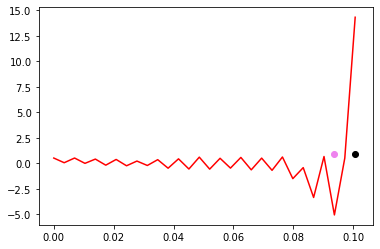

[14.326633165829149, -5.070095084298186, 0.2147031771857153, 8.027827853881211]


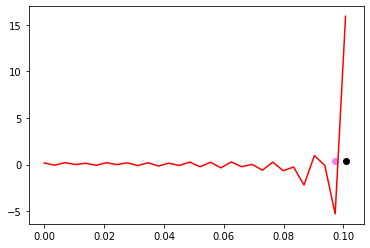

[15.927927927927925, -5.297421246547184, 0.28607074233314284, 9.247399479494854]


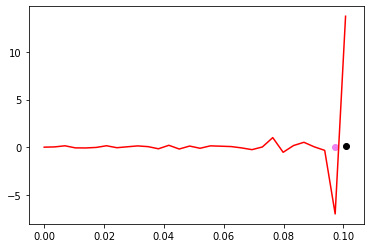

[13.72535211267606, -6.985991516976348, 0.2572668850423357, 7.650648607255781]


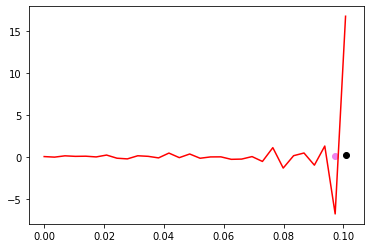

[16.782608695652172, -6.794222980012557, 0.3417569416995783, 10.680004138165156]


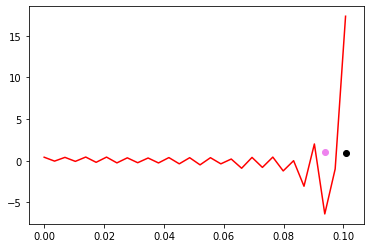

[17.336065573770494, -6.3911940356220605, 0.2556510794448601, 11.589056011374208]


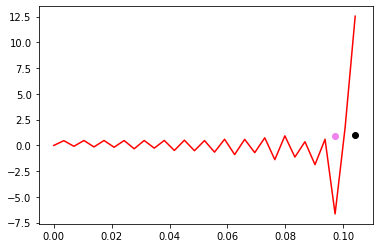

[12.533018867924527, -6.663356027677623, 0.20373372945466722, 6.994466367135678]


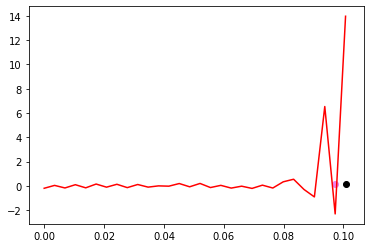

[13.975806451612902, -2.31983074508706, 0.5468053873344864, 7.609019292503358]


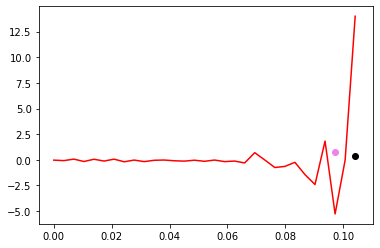

[14.0, -5.278458123062236, 0.12766067905102757, 7.626860357555492]


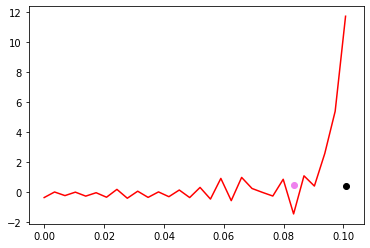

[11.728813559322033, -1.4309898922191395, 0.647055125458785, 5.424644256179081]


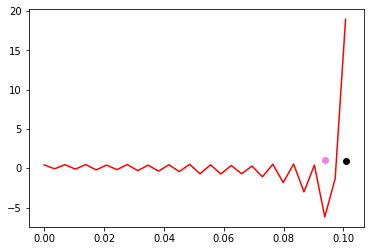

[18.967741935483875, -6.181013520056172, 0.262796826845287, 13.410692153304774]


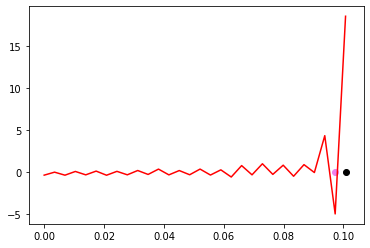

[18.517647058823528, -4.931077142430149, 0.6171195335115922, 12.24605487548724]


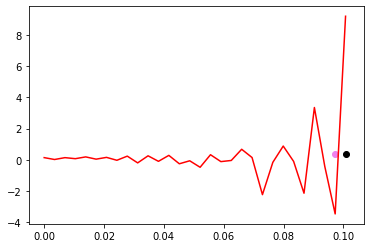

[9.190476190476218, -3.4705437287842456, 0.19757870430484872, 3.8164962668992093]


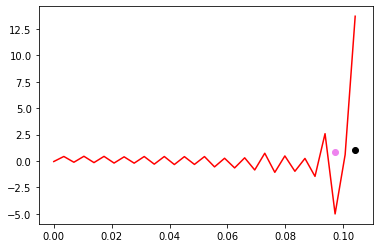

[13.688405797101447, -4.9976635517825825, 0.32846880387939686, 7.243823457865278]


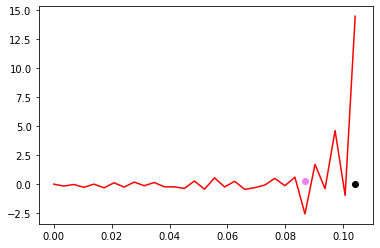

[14.486666666666668, -2.5863388322407466, 0.4962459777060816, 7.627413047890106]


[[16.23275862068966,
  -5.877074392438965,
  0.26505483531442803,
  10.28379113775924],
 [14.055944055944055, -7.5160381855702, 0.2294012147385561, 8.249634519607687],
 [17.189189189189193,
  -3.4512267927737463,
  0.27349432264737567,
  10.358458001029735],
 [12.620000000000005,
  -1.4726485094796553,
  0.5836565725069344,
  5.874725650530752],
 [13.835164835164836,
  -4.981139065082994,
  0.2878948813836156,
  7.695201621278084],
 [15.286666666666669,
  -5.6342455443435755,
  0.20037942723745408,
  8.900493246430312],
 [19.734104046242773,
  -4.160667933541003,
  0.3350718558985441,
  13.432658458338363],
 [15.16346153846154, -7.292589382056879, 0.2311110357184811, 9.14391184454229],
 [19.295454545454547,
  -4.805278600204271,
  0.26756502907640334,
  13.735187147697346],
 [21.879432624113477,
  -3.6579025288576306,
  0.40850542678736973,
  16.179239157151333],
 [4.084745762711864,
  -1.7532647872546008,
  0.3278550083574959,
  1.6472626943511666],
 [21.099378881987576,
  -4.26402665

In [13]:
Feature_vector=[]
for i in range(0, len(cgmSeries_np)):
#FFT
    fastfouriertransform=rfft(cgmNorm_np[i])
    plt.figure()
    plt.plot(cgmSeries_np[i], fastfouriertransform, c='red')
    fft_max=np.nanmax(fastfouriertransform)
    s=np.where(fastfouriertransform == fft_max)
    plt.scatter(cgmSeries_np[i][s],cgmNorm_np[i][s], c='black')
    fft_min=np.nanmin(fastfouriertransform)
    s=np.where(fastfouriertransform == fft_min)
    plt.scatter(cgmSeries_np[i][s],cgmNorm_np[i][s], c='violet')
    fft_mean=np.nanmean(fastfouriertransform)
    fft_variance=np.nanvar(fastfouriertransform)
    Feature_vector.append([fft_max,fft_min,fft_mean,fft_variance])
    plt.show()
    print([fft_max,fft_min,fft_mean,fft_variance])
display(Feature_vector)   

# 2. Generating Feature Matrix, Visualizing Spread and PCA

In [14]:
# Feature Matrix
matrix = []
for i in range(0, len(cgmSeries_np)):
    matrix_row = np.array([])
    # Anirudh
    matrix_row = np.append(matrix_row, slopes[i])
    matrix_row = np.append(matrix_row, time_diffs[i])
    matrix_row = np.append(matrix_row, peak_values[i])
    matrix_row = np.append(matrix_row, peak_heights[i])
    matrix_row = np.append(matrix_row, peak_times[i])
    # Vedant
    matrix_row = np.append(matrix_row, window_mins[i])
    matrix_row = np.append(matrix_row, window_maxs[i])
    matrix_row = np.append(matrix_row, window_vars[i])
    matrix_row = np.append(matrix_row, window_means[i])
    # Omkar
    matrix_row = np.append(matrix_row, mean_before[i])
    matrix_row = np.append(matrix_row, mean_after[i])
    matrix_row = np.append(matrix_row, mean_dif[i])
    # Ananth
    matrix_row = np.append(matrix_row, Feature_vector[i])
    if len(matrix) == 0:
        matrix = np.array([matrix_row])
    else:
        matrix = np.append(matrix, [matrix_row], axis=0)
       
matrix = np.nan_to_num(matrix)
# Normalizing Values
# print(np.nan_to_num(np.log(np.nan)))
means = np.mean(matrix, axis=0)
mean_great = np.argwhere(means > 1).flatten()
mean_small = np.argwhere(means < -1).flatten()
# for i in mean_great:
#     print(i)
#     matrix[i][:] = np.nan_to_num(np.log(matrix[i][:]))
# transformer = pre.FunctionTransformer(np.log1p, validate=True)
# matrix = transformer.transform(matrix)
# matrix = np.nan_to_num(matrix)

In [15]:
# Converting to dataframe for easy visualization
columns = np.array(['Slope_minmax', 'TimeDiff_minmax', 
           'PeakVal1_error', 'PeakVal2_error', 'PeakHt1_error', 'PeakHt2_error', 'PeakTime1_error', 'PeakTime2_error', 
           'Min1_window', 'Min2_window', 'Max1_window', 'Max2_window', 'Var1_window', 'Var2_window', 'Mean1_window', 'Mean2_window', 
           'Mean_before', 'Mean_after', 'Mean_diff',
           'Max_fft', 'Min_fft', 'Mean_fft', 'Var_fft'
          ])
feature_df = pd.DataFrame(matrix, columns=columns)
for i in mean_great:
    feature_df[columns[i]] = np.nan_to_num(np.log10(feature_df[columns[i]].replace(0, np.nan)))
for i in mean_small:
    feature_df[columns[i]] = np.sign(feature_df[columns[i]])*np.nan_to_num(np.log10(np.abs(feature_df[columns[i]].replace(0, np.nan))))
    #     print()
display(feature_df)
feature_df.to_csv('Features_'+str(patient)+'.csv')

,Slope_minmax,TimeDiff_minmax,PeakVal1_error,PeakVal2_error,PeakHt1_error,PeakHt2_error,PeakTime1_error,PeakTime2_error,Min1_window,Min2_window,...,Var2_window,Mean1_window,Mean2_window,Mean_before,Mean_after,Mean_diff,Max_fft,Min_fft,Mean_fft,Var_fft
0,1.116904,0.076400,0.775862,0.465517,0.206897,0.261638,0.069456,0.034722,0.491379,0.422414,...,0.023276,0.717241,0.613793,0.034483,0.627155,0.592672,1.210392,-0.769161,0.265055,1.012153
1,1.459392,0.034722,0.930070,0.636364,0.162005,0.184149,0.038194,0.027778,0.188811,0.076923,...,0.051093,0.499301,0.353846,0.107517,0.598220,0.490702,1.147860,-0.875989,0.229401,0.916435
2,1.418000,0.038194,0.243243,1.000000,0.173423,0.435208,0.010417,0.038194,0.472973,0.445946,...,0.051169,0.775676,0.664865,0.445946,0.633634,0.187688,1.235255,-0.537973,0.273494,1.015295
3,0.000000,0.000000,0.620000,0.220000,0.520000,0.620000,0.062500,0.020833,0.140000,0.360000,...,0.084280,0.532000,0.704000,0.886667,0.367407,-0.519259,1.101059,-0.168099,0.583657,0.768988
4,1.079181,0.083333,0.142857,0.560440,0.146520,0.241758,0.027778,0.048611,0.439560,0.384615,...,0.025939,0.657143,0.564835,0.164835,0.436908,0.272073,1.140984,-0.697329,0.287895,0.886220
5,1.283301,0.052083,0.446667,0.973333,0.034444,0.191111,0.086829,0.048611,0.533333,0.626667,...,0.021622,0.725333,0.813333,0.061111,0.610278,0.549167,1.184313,-0.750836,0.200379,0.949414
6,1.204040,0.062512,0.410405,0.763006,0.281310,0.315992,0.013889,0.038206,0.000000,0.075145,...,0.028845,0.205780,0.308671,0.292320,0.743906,0.451585,1.295217,-0.619163,0.335072,1.128162
7,1.283108,0.052106,0.971154,0.817308,0.189103,0.264423,0.055579,0.038218,0.432692,0.269231,...,0.026747,0.651923,0.457692,0.112179,0.600561,0.488381,1.180798,-0.862882,0.231111,0.961132
8,1.418000,0.038194,0.427273,0.918182,0.200758,0.329545,0.024306,0.038194,0.150000,0.204545,...,0.063126,0.430000,0.561818,0.071023,0.816736,0.745713,1.285455,-0.681719,0.267565,1.137835
9,1.345449,0.045139,0.865248,0.276596,0.130024,0.144208,0.034722,0.006944,0.000000,0.085106,...,0.031603,0.241135,0.350355,0.291962,0.807624,0.515662,1.340036,-0.563232,0.408505,1.208958


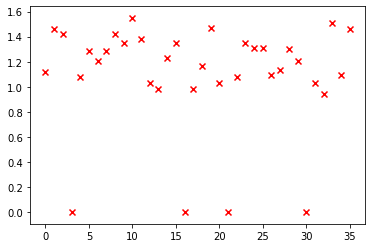

<Figure size 432x288 with 0 Axes>

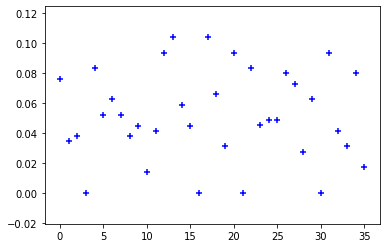

<Figure size 432x288 with 0 Axes>

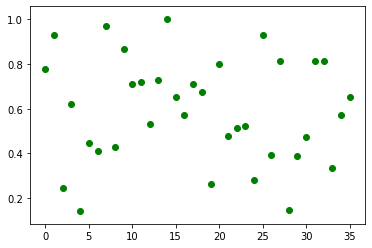

<Figure size 432x288 with 0 Axes>

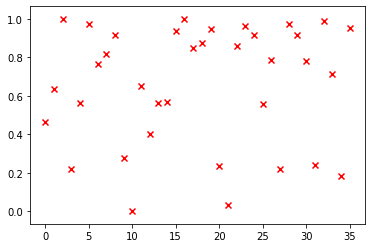

<Figure size 432x288 with 0 Axes>

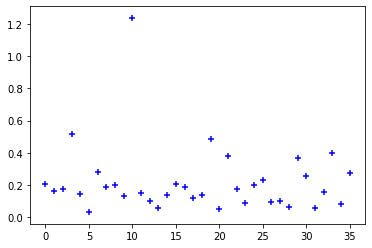

<Figure size 432x288 with 0 Axes>

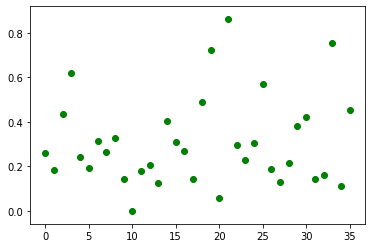

<Figure size 432x288 with 0 Axes>

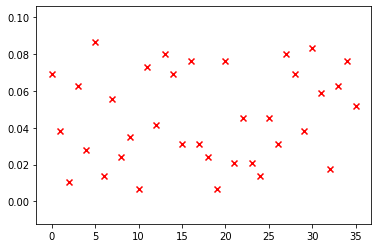

<Figure size 432x288 with 0 Axes>

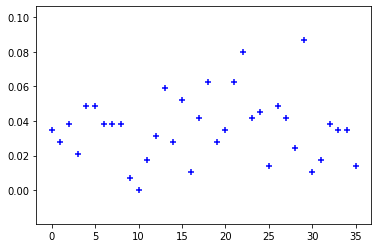

<Figure size 432x288 with 0 Axes>

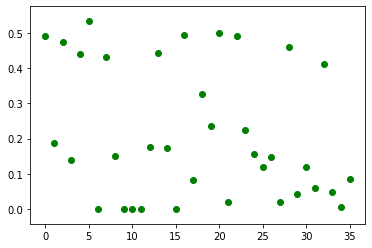

<Figure size 432x288 with 0 Axes>

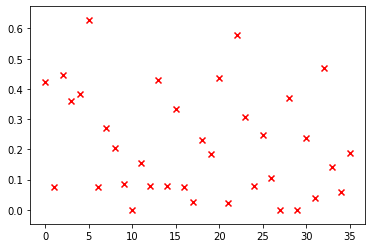

<Figure size 432x288 with 0 Axes>

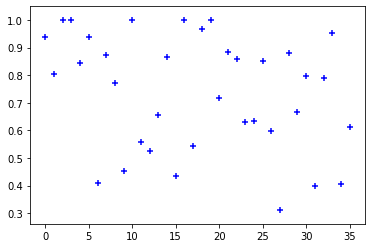

<Figure size 432x288 with 0 Axes>

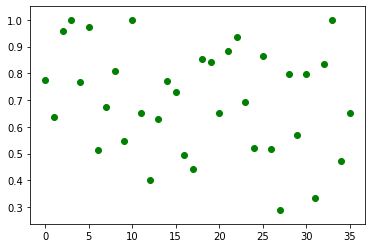

<Figure size 432x288 with 0 Axes>

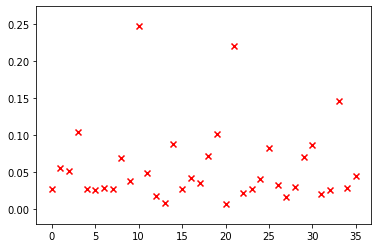

<Figure size 432x288 with 0 Axes>

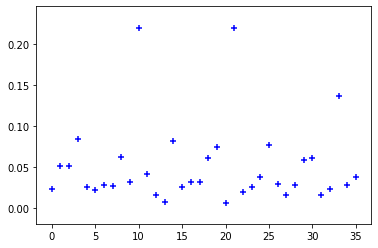

<Figure size 432x288 with 0 Axes>

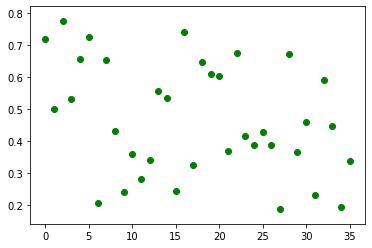

<Figure size 432x288 with 0 Axes>

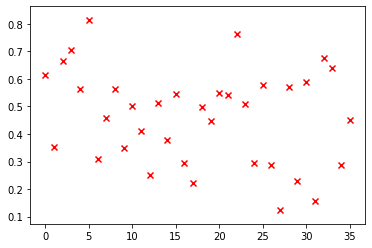

<Figure size 432x288 with 0 Axes>

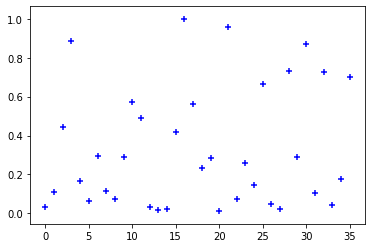

<Figure size 432x288 with 0 Axes>

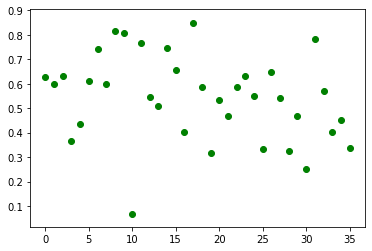

<Figure size 432x288 with 0 Axes>

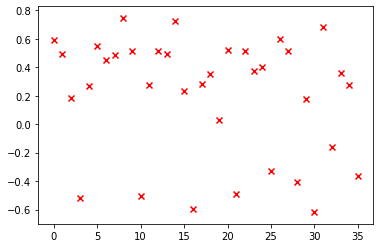

<Figure size 432x288 with 0 Axes>

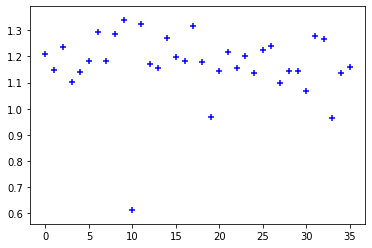

<Figure size 432x288 with 0 Axes>

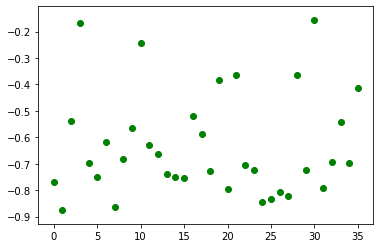

<Figure size 432x288 with 0 Axes>

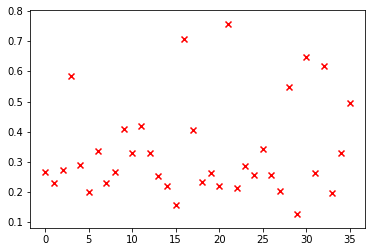

<Figure size 432x288 with 0 Axes>

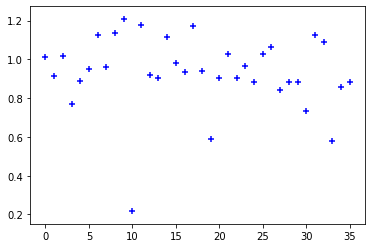

<Figure size 432x288 with 0 Axes>

In [16]:
matrix = feature_df.values
means = np.mean(matrix, axis=0)
# print(means)
# Scatter Visualization
rows = [i for i in range(len(cgmNorm_np))]
colors = ['red', 'blue', 'green']
markers = ['x', '+', 'o']
for i in range(0, matrix.shape[1]):
    plt.figure()
    plt.scatter(rows, matrix[:, i], color=colors[i%3] ,marker=markers[i%3])
    plt.show()
    # Save Images
    plt.savefig('Images/Patient' + str(patient) + '/' + columns[i] + '.png')

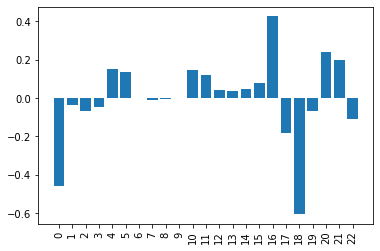

0.43328199495096215
['Mean_diff' 'Slope_minmax' 'Mean_after' 'Var_fft' 'PeakVal1_error'
 'Max_fft' 'PeakVal2_error' 'TimeDiff_minmax' 'PeakTime2_error'
 'Min1_window' 'Min2_window' 'PeakTime1_error' 'Var2_window' 'Var1_window'
 'Mean1_window' 'Mean2_window' 'Max2_window' 'PeakHt2_error' 'Max1_window'
 'PeakHt1_error' 'Mean_fft' 'Min_fft' 'Mean_before']
[-0.60458747 -0.46016874 -0.17954212 -0.1098058  -0.06619897 -0.06473983
 -0.0446448  -0.03336802 -0.0086635  -0.00596118 -0.00150129  0.00090469
  0.03843528  0.04442294  0.04730326  0.07898191  0.11807405  0.13452622
  0.14730175  0.15132861  0.20061478  0.23907961  0.42504535]


<Figure size 432x288 with 0 Axes>

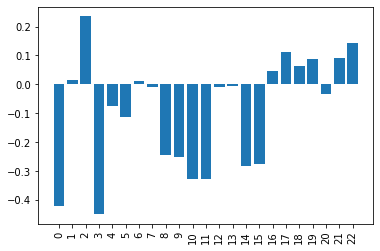

0.18471980857036988
['PeakVal2_error' 'Slope_minmax' 'Max2_window' 'Max1_window'
 'Mean1_window' 'Mean2_window' 'Min2_window' 'Min1_window' 'PeakHt2_error'
 'PeakHt1_error' 'Min_fft' 'Var1_window' 'PeakTime2_error' 'Var2_window'
 'PeakTime1_error' 'TimeDiff_minmax' 'Mean_before' 'Mean_diff' 'Max_fft'
 'Mean_fft' 'Mean_after' 'Var_fft' 'PeakVal1_error']
[-0.44940742 -0.42019369 -0.32633624 -0.32618933 -0.2825894  -0.27463107
 -0.25208177 -0.24355632 -0.11205258 -0.0761088  -0.03267404 -0.00830707
 -0.00766345 -0.0058546   0.01298141  0.01465109  0.04582775  0.06501219
  0.08622924  0.0921936   0.11083995  0.14443509  0.23465189]


<Figure size 432x288 with 0 Axes>

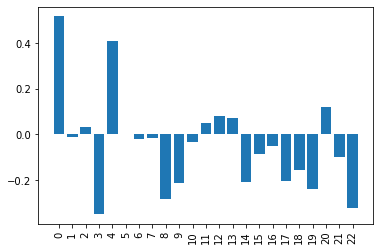

0.14741582593930166
['PeakVal2_error' 'Var_fft' 'Min1_window' 'Max_fft' 'Min2_window'
 'Mean1_window' 'Mean_after' 'Mean_diff' 'Mean_fft' 'Mean2_window'
 'Mean_before' 'Max1_window' 'PeakTime1_error' 'PeakTime2_error'
 'TimeDiff_minmax' 'PeakHt2_error' 'PeakVal1_error' 'Max2_window'
 'Var2_window' 'Var1_window' 'Min_fft' 'PeakHt1_error' 'Slope_minmax']
[-3.48167092e-01 -3.22523688e-01 -2.83081744e-01 -2.37375823e-01
 -2.13256304e-01 -2.08637521e-01 -2.04630822e-01 -1.55012384e-01
 -9.97760058e-02 -8.44037451e-02 -4.96184388e-02 -3.48798522e-02
 -1.76252344e-02 -1.57515643e-02 -1.26793796e-02  1.47631912e-04
  3.24630540e-02  4.91005106e-02  7.30568908e-02  8.13657840e-02
  1.20908051e-01  4.07537672e-01  5.15518774e-01]


<Figure size 432x288 with 0 Axes>

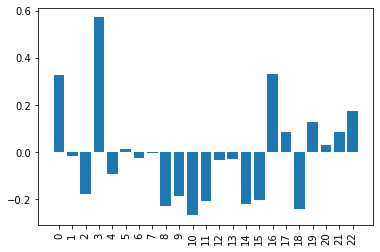

0.09806049940412039
['Max1_window' 'Mean_diff' 'Min1_window' 'Mean1_window' 'Max2_window'
 'Mean2_window' 'Min2_window' 'PeakVal1_error' 'PeakHt1_error'
 'Var1_window' 'Var2_window' 'PeakTime1_error' 'TimeDiff_minmax'
 'PeakTime2_error' 'PeakHt2_error' 'Min_fft' 'Mean_fft' 'Mean_after'
 'Max_fft' 'Var_fft' 'Slope_minmax' 'Mean_before' 'PeakVal2_error']
[-0.26775219 -0.24366194 -0.22965785 -0.2206516  -0.20964783 -0.20487988
 -0.18660264 -0.17744365 -0.09499556 -0.03280964 -0.03093927 -0.02436716
 -0.01740599 -0.00553554  0.01124251  0.02816549  0.08397919  0.08590623
  0.12809698  0.17541303  0.3264099   0.32956817  0.57061241]


<Figure size 432x288 with 0 Axes>

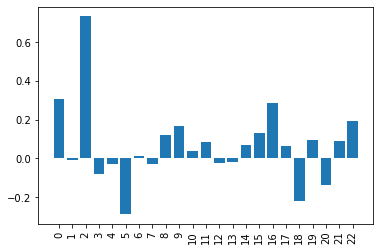

0.05783952671617862
['PeakHt2_error' 'Mean_diff' 'Min_fft' 'PeakVal2_error' 'PeakTime2_error'
 'PeakHt1_error' 'Var1_window' 'Var2_window' 'TimeDiff_minmax'
 'PeakTime1_error' 'Max1_window' 'Mean_after' 'Mean1_window' 'Max2_window'
 'Mean_fft' 'Max_fft' 'Min1_window' 'Mean2_window' 'Min2_window' 'Var_fft'
 'Mean_before' 'Slope_minmax' 'PeakVal1_error']
[-0.28728439 -0.22153378 -0.13683013 -0.07867492 -0.03012143 -0.02776776
 -0.02436522 -0.02028887 -0.00618202  0.01390783  0.03846856  0.06381849
  0.06985094  0.08542602  0.08966582  0.09440238  0.11997055  0.12903673
  0.16808522  0.19077992  0.28535227  0.30670539  0.73122817]


<Figure size 432x288 with 0 Axes>

In [17]:
# PCA
pca = PCA(n_components=5)
pca.fit(matrix)
components = pca.components_
variances = pca.explained_variance_
x = [i for i in range(0, len(components[0]))]
for i in range(0, 5):
    plt.figure()
    plt.bar(x, components[i])
    plt.xticks(np.arange(len(components[0])), x, rotation=90)
    plt.show()
    positives = np.array(np.argwhere(components[i] > 0).flatten())
    positive_sorted = np.argsort(components[i][:])
    positives = positive_sorted
#     print(components[i])
#     print(positives)
#     print(columns)
    print(variances[i])
    print(columns[positives])
    print(components[i][positives])
    plt.savefig('Images/Patient' + str(patient) + '/' + 'PCA' + str(i) + '.png')
#     print(components[i])